In [1]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy  --upgrade --quiet
# !pip3 install scipy --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quiet
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade  --quiet
# !pip install scikit-optimize  --quiet
# !pip install -U --quiet yellowbrick
# !pip install apafib --upgrade  --quiet
# !pip install --upgrade pip
# !pip install ucimlrepo
# !pip install missingno --upgrade --quiet
# !pip install torch --upgrade --quiet

In [2]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
import matplotlib.dates as mdates

from scipy import stats
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy
import re


import warnings
warnings.filterwarnings('ignore')

# Definiciones
RND = 16
MAX_ITER = 5000

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                
    else:
        mant = p / (10.0**exp)
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    
# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

init_time = time()

# Práctica de APA. Preprocesado de las variables.

## Introducción

Autores: Oriol Farrés y Marc Gil

Como los datos van de 2011 a 2024, vamos a dividirlos temporalmente:

* **Train**: 2011-2020 (10 años, ~70%)
* **Test**: 2021-2024 (4 años, ~30%)

Esta división es importante porque respeta el orden cronológico y simula mejor cómo usaríamos el modelo en la práctica (entrenando con datos pasados para predecir futuros).

---

Al tener tal cantidad de trabajo con el preprocesado de las variables para el problema, para asegurarnos de que hay consistencia y evitar cometer errores metodológicos, seguiremos la siguiente estructura (basada en la lista propuesta en el LAB y en el guión de la práctica): 




**Fase A: Obtención de los datos**

1. Preámbulo

**Fase B: Limpieza de los datos**

1. Preparar las variables (Sanity Check)
2. Tratamiento de valores incoherentes o incorrectos
3. Tratamiento de missing values
4. Tratamiento de outliers
5. Crear nuevas variables que pueden ser interesantes (Feature engineering)
6. Re-nombrado de las variables
7. Feature engineering (computar diferencias)
8. Eliminar data leakage

**Fase C: Separación de los datos**

1. División del dataset en train/test 

**Fase D: Análisis**

1. Exploratorio Mínimo


**Fase Final: Guardar dataset limpio**

---

Al final guardamos todo en formato parquet para mantener los tipos de datos.

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase A-Obtención de los datos

## A.1-Preámbulo

> Tenemos todo el dataset preparado en el directorio data/raw/raw_atp_matches.csv.

In [3]:
tennis = pd.read_csv('./data/raw/raw_atp_matches.csv')
tennis.head()

tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0   2011-339     Brisbane    Hard         32             A      20110102   
1   2011-339     Brisbane    Hard         32             A      20110102   
2   2011-339     Brisbane    Hard         32             A      20110102   
3   2011-339     Brisbane    Hard         32             A      20110102   
4   2011-339     Brisbane    Hard         32             A      20110102   

   match_num  winner_id  winner_seed winner_entry  ... l_bpFaced winner_rank  \
0          1     104417          1.0          NaN  ...       4.0         5.0   
1          2     103582          NaN          NaN  ...       5.0        58.0   
2          3     105051          NaN            Q  ...       8.0       196.0   
3          4     104797          8.0          NaN  ...       3.0        40.0   
4          5     103888          4.0          NaN  ...       6.0        16.0   

   winner_rank_points loser_rank  loser_rank_points  year  month day  \
0              5580.0      173.0              309.0  2011      1   2   
1               835.0       75.0              643.0  2011      1   2   
2               263.0      204.0              243.0  2011      1   2   
3              1031.0       43.0              975.0  2011      1   2   
4              1991.0       83.0              600.0  2011      1   2   

  month_name tourney_points  
0    January            250  
1    January            250  
2    January            250  
3    January            250  
4    January            250  

[5 rows x 54 columns]

In [4]:
tennis.describe(include='all').T

count unique               top   freq             mean  \
tourney_id            39541   1894          2011-580    127              NaN   
tourney_name          39541   1078     Roland Garros   1778              NaN   
surface               39488      4              Hard  23060              NaN   
draw_size           39541.0    NaN               NaN    NaN        57.467489   
tourney_level         39541      6                 A  21148              NaN   
tourney_date        39541.0    NaN               NaN    NaN  20174404.064313   
match_num           39541.0    NaN               NaN    NaN       167.239802   
winner_id           39541.0    NaN               NaN    NaN    117737.747477   
winner_seed         16884.0    NaN               NaN    NaN         7.543592   
winner_entry           5347     10                 Q   2968              NaN   
winner_name           39541   1051    Novak Djokovic    813              NaN   
winner_hand           39541      4                 R  34321              NaN   
winner_ht           39113.0    NaN               NaN    NaN       187.368727   
winner_ioc            39541     97               ESP   4242              NaN   
winner_age          39538.0    NaN               NaN    NaN        27.192106   
loser_id            39541.0    NaN               NaN    NaN    117705.261501   
loser_seed           9571.0    NaN               NaN    NaN         9.048062   
loser_entry            8546     11                 Q   4618              NaN   
loser_name            39541   1480  Adrian Mannarino    333              NaN   
loser_hand            39537      3                 R  33658              NaN   
loser_ht            38573.0    NaN               NaN    NaN       186.543411   
loser_ioc             39541    102               FRA   3693              NaN   
loser_age           39538.0    NaN               NaN    NaN        27.197987   
score                 39541   7974           6-3 6-4   1355              NaN   
best_of             39541.0    NaN               NaN    NaN         3.433929   
round                 39541      9               R32  12112              NaN   
minutes             35502.0    NaN               NaN    NaN       111.034702   
w_ace               37143.0    NaN               NaN    NaN         7.172065   
w_df                37143.0    NaN               NaN    NaN         2.607625   
w_svpt              37143.0    NaN               NaN    NaN        78.779743   
w_1stIn             37143.0    NaN               NaN    NaN        49.114961   
w_1stWon            37143.0    NaN               NaN    NaN        37.279595   
w_2ndWon            37143.0    NaN               NaN    NaN        16.468944   
w_SvGms             37143.0    NaN               NaN    NaN        12.681986   
w_bpSaved           37143.0    NaN               NaN    NaN         3.439679   
w_bpFaced           37143.0    NaN               NaN    NaN         4.973481   
l_ace               37143.0    NaN               NaN    NaN         5.318714   
l_df                37143.0    NaN               NaN    NaN          3.28288   
l_svpt              37143.0    NaN               NaN    NaN        81.837385   
l_1stIn             37143.0    NaN               NaN    NaN        49.756105   
l_1stWon            37143.0    NaN               NaN    NaN        33.378645   
l_2ndWon            37143.0    NaN               NaN    NaN        14.871604   
l_SvGms             37143.0    NaN               NaN    NaN        12.447325   
l_bpSaved           37143.0    NaN               NaN    NaN         4.762701   
l_bpFaced           37143.0    NaN               NaN    NaN         8.522979   
winner_rank         39300.0    NaN               NaN    NaN        75.102875   
winner_rank_points  39300.0    NaN               NaN    NaN      1907.322392   
loser_rank          38919.0    NaN               NaN    NaN       112.062823   
loser_rank_points   38919.0    NaN               NaN    NaN      1123.764434   
year                39

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B-Limpieza de los datos

Antes de empezar con la limpieza, vamos a ver cuantas filas tenemos en el dataset, para asegurarnos de que no cometemos ningún error.

In [5]:
print(f"Nuestro dataset tiene {tennis.shape[1]} variables y {tennis.shape[0]:,} columnas.")

Nuestro dataset tiene 54 variables y 39,541 columnas.


## B.1-Preparar las variables (Sanity Check)

### Eliminar partidos inválidos

Hay partidos donde uno de los jugadores se retiró o no se presentó (W/O, RET, etc). Estos no son útiles porque son impredecibles:

In [6]:
tennis['score'].head()

0           6-2 6-4
1    1-6 7-6(3) 6-2
2       4-6 6-2 6-4
3        7-6(5) 6-4
4           6-1 6-4
Name: score, dtype: object

In [7]:
# Ver los 20 resultados más comunes (para ver lo "habitual")
print("Lo habitual:")
print(tennis['score'].value_counts().head(10))

print("\n----------------\n")

scores_con_letras = tennis[tennis['score'].str.contains('[a-zA-Z]', na=False)]['score']

print("Scores sospechosos (contiene letras):")
print(scores_con_letras.unique())

Lo habitual:
score
6-3 6-4    1355
6-4 6-4    1330
6-3 6-2     849
6-4 6-3     803
6-4 6-2     787
6-3 6-3     728
6-2 6-4     632
6-2 6-2     548
6-2 6-3     499
6-1 6-4     432
Name: count, dtype: int64

----------------

Scores sospechosos (contiene letras):
['6-2 RET' '6-0 5-0 RET' '6-3 6-1 4-2 RET' '6-1 6-0 2-0 RET'
 '6-7(5) 6-2 6-1 4-3 RET' 'W/O' '5-2 RET' '6-2 1-0 RET' '6-1 0-1 RET'
 '3-6 6-5 RET' '4-0 RET' '6-1 2-0 RET' '5-0 RET' '6-7(5) 6-2 4-2 RET'
 '4-5 RET' '6-2 4-1 RET' '6-4 RET' '7-5 2-0 RET' '5-4 RET' '6-1 5-3 RET'
 '6-4 3-1 RET' '3-0 RET' '3-4 RET' '3-6 2-1 RET' '4-6 6-1 2-0 RET'
 '2-6 4-2 RET' '5-1 RET' '6-3 4-0 RET' '4-6 6-1 4-4 RET'
 '7-6(6) 3-6 5-2 RET' '6-2 3-0 RET' '6-7(5) 6-3 3-0 RET' '6-4 1-0 RET'
 '7-6(1) 1-0 RET' '6-2 2-0 RET' '4-6 6-3 6-2 3-1 RET' '6-4 6-1 2-3 RET'
 '4-3 RET' '6-4 6-6 RET' '7-6(5) 2-0 RET' '6-7(4) 6-4 3-0 RET'
 '7-6(5) 3-6 5-3 RET' '7-5 3-1 RET' '6-3 6-3 RET' '6-4 4-2 RET' '2-3 RET'
 '6-3 6-7(5) 6-2 1-1 RET' '6-7 6-3 6-1 RET' '2-6 6-2 6-3 2-0

In [8]:
print(f"Partidos antes de limpiar score: {len(tennis)}")

tennis['score'] = tennis['score'].astype(str)
filtro_score_sucio = tennis['score'].str.contains('W/O|RET|Def|Walkover|Aban|ABD', case=False, na=False)

print(f"\nEliminando {filtro_score_sucio.sum()} partidos inválidos")
tennis = tennis[~filtro_score_sucio].copy()
tennis.reset_index(drop=True, inplace=True)

print(f"Partidos después: {len(tennis)}")

Partidos antes de limpiar score: 39541

Eliminando 1398 partidos inválidos
Partidos después: 38143


In [9]:
scores_con_letras = tennis[tennis['score'].str.contains('[a-zA-Z]', na=False)]['score']

print("Lo sospechoso (contiene letras):")
print(scores_con_letras.unique())

Lo sospechoso (contiene letras):
[]


---

### B.1-Paso 2. Tratar variables temporales

In [10]:
tennis['tourney_date'].head()

0    20110102
1    20110102
2    20110102
3    20110102
4    20110102
Name: tourney_date, dtype: int64

Las fechas vienen como enteros tipo YYYYMMDD. Las convertimos a datetime:

In [11]:
tennis['tourney_date'] = pd.to_datetime(tennis['tourney_date'].astype(int).astype(str), format='%Y%m%d')
tennis['tourney_date'].head()

0   2011-01-02
1   2011-01-02
2   2011-01-02
3   2011-01-02
4   2011-01-02
Name: tourney_date, dtype: datetime64[ns]

In [12]:
# Extraemos el Año y Mes (muy útil para el análisis exploratorio posterior)
tennis['year'] = tennis['tourney_date'].dt.year
tennis['month'] = tennis['tourney_date'].dt.month

In [13]:
# Ahora que tenemos fechas reales, ordenamos todo el dataset por fecha.
tennis = tennis.sort_values(by='tourney_date').reset_index(drop=True)

---
---

## B.2-Tratamiento de valores incoherentes

In [14]:
tennis.describe(include='all').T

count unique             top   freq  \
tourney_id            38143   1894        2018-540    126   
tourney_name          38143   1078   Roland Garros   1723   
surface               38092      4            Hard  22196   
draw_size           38143.0    NaN             NaN    NaN   
tourney_level         38143      6               A  20413   
tourney_date          38143    NaN             NaN    NaN   
match_num           38143.0    NaN             NaN    NaN   
winner_id           38143.0    NaN             NaN    NaN   
winner_seed         16345.0    NaN             NaN    NaN   
winner_entry           5130     10               Q   2857   
winner_name           38143   1037  Novak Djokovic    781   
winner_hand           38143      4               R  33114   
winner_ht           37743.0    NaN             NaN    NaN   
winner_ioc            38143     97             ESP   4086   
winner_age          38140.0    NaN             NaN    NaN   
loser_id            38143.0    NaN             NaN    NaN   
loser_seed           9147.0    NaN             NaN    NaN   
loser_entry            8355     10               Q   4517   
loser_name            38143   1475    Albert Ramos    327   
loser_hand            38139      3               R  32444   
loser_ht            37199.0    NaN             NaN    NaN   
loser_ioc             38143    102             FRA   3547   
loser_age           38140.0    NaN             NaN    NaN   
score                 38143   7392         6-3 6-4   1355   
best_of             38143.0    NaN             NaN    NaN   
round                 38143      9             R32  11686   
minutes             34406.0    NaN             NaN    NaN   
w_ace               36047.0    NaN             NaN    NaN   
w_df                36047.0    NaN             NaN    NaN   
w_svpt              36047.0    NaN             NaN    NaN   
w_1stIn             36047.0    NaN             NaN    NaN   
w_1stWon            36047.0    NaN             NaN    NaN   
w_2ndWon            36047.0    NaN             NaN    NaN   
w_SvGms             36046.0    NaN             NaN    NaN   
w_bpSaved           36047.0    NaN             NaN    NaN   
w_bpFaced           36047.0    NaN             NaN    NaN   
l_ace               36047.0    NaN             NaN    NaN   
l_df                36047.0    NaN             NaN    NaN   
l_svpt              36047.0    NaN             NaN    NaN   
l_1stIn             36047.0    NaN             NaN    NaN   
l_1stWon            36047.0    NaN             NaN    NaN   
l_2ndWon            36047.0    NaN             NaN    NaN   
l_SvGms             36046.0    NaN             NaN    NaN   
l_bpSaved           36047.0    NaN             NaN    NaN   
l_bpFaced           36047.0    NaN             NaN    NaN   
winner_rank         37914.0    NaN             NaN    NaN   
winner_rank_points  37914.0    NaN             NaN    NaN   
loser_rank          37540.0    NaN             NaN    NaN   
loser_rank_points   37540.0    NaN             NaN    NaN   
year                38143.0    NaN             NaN    NaN   
month               38143.0    NaN             NaN    NaN   
day                 38143.0    NaN             NaN    NaN   
month_name            38143     12        February   5172   
tourney_points      38143.0    NaN             NaN    NaN   

                                             mean                  min  \
tourney_id                                    NaN                  NaN   
tourney_name                                  NaN                  NaN   
surface                                       NaN                  NaN   
draw_size                               57.351493                  2.0   
tourney_level                                 NaN                  NaN   
tourney_date        2017-10-25 17:39:49.838240256  2011-01-02 00:00:00   
match_num                               167.72805                  1.0   
winner_id                           117711.416643             100644.0   



Vemos que hay alturas con valores mínimos de 3.0 cm, lo cual es imposible. Hay que limpiarlas:

### B.2-Paso 1. Arreglar alturas.

In [15]:
# Definimos el umbral de corte (160 cm es muy bajito para ATP)
umbral_altura = 160

mask_bajos = (tennis['winner_ht'] < umbral_altura) | (tennis['loser_ht'] < umbral_altura)
cols_interes = ['tourney_date', 'winner_name', 'winner_ht', 'loser_name', 'loser_ht', 'score']
sospechosos = tennis.loc[mask_bajos, cols_interes]

print(f"Registros con alturas < {umbral_altura}cm: {len(sospechosos)}")
display(sospechosos.head(10))

nombres_w = tennis.loc[tennis['winner_ht'] < umbral_altura, 'winner_name'].unique()
nombres_l = tennis.loc[tennis['loser_ht'] < umbral_altura, 'loser_name'].unique()

print("\nJugadores afectados (winner):", nombres_w)
print("Jugadores afectados (loser):", nombres_l)

Registros con alturas < 160cm: 11


tourney_date                 winner_name  winner_ht  \
5338    2012-09-14              Roberto Quiroz      193.0   
6088    2013-02-01  Jorge Brian Panta Herreros        3.0   
6702    2013-04-05         Luis David Martinez      178.0   
14865   2016-03-04  Jorge Brian Panta Herreros        3.0   
20155   2018-02-03  Jorge Brian Panta Herreros        3.0   
28928   2021-09-17              Kasidit Samrej      191.0   
30107   2022-03-04         Ramkumar Ramanathan      188.0   
31691   2022-09-15            Marton Fucsovics      188.0   
31761   2022-09-17          Johannes Ingildsen       15.0   
32590   2023-02-03       Viacheslav Bielinskyi       71.0   

                       loser_name  loser_ht                      score  
5338   Jorge Brian Panta Herreros       3.0                 7-6(8) 6-1  
6088              Hillel Rousseau     180.0                    6-1 6-0  
6702   Jorge Brian Panta Herreros       3.0             3-6 7-6(4) 6-3  
14865               Martin Cuevas     191.0  5-7 7-5 6-7(5) 7-6(4) 6-4  
20155           Alejandro Mendoza     183.0                    6-2 6-4  
28928          Johannes Ingildsen      15.0                    7-5 6-3  
30107          Johannes Ingildsen      15.0             5-7 7-5 [10-7]  
31691       Viacheslav Bielinskyi      71.0                    6-3 6-2  
31761                  Cesar Cruz       NaN                    6-4 6-4  
32590             Benjamin Hassan     183.0                6-4 2-6 6-4


Jugadores afectados (winner): ['Jorge Brian Panta Herreros' 'Johannes Ingildsen' 'Viacheslav Bielinskyi']
Jugadores afectados (loser): ['Jorge Brian Panta Herreros' 'Johannes Ingildsen' 'Viacheslav Bielinskyi']


Al tratarse de solo 3 jugadores los buscaremos y los copiaremos de google.

* Altura de Jorge: 173cm. [Referencia.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjo8O662daRAxVAUaQEHXiVMSwQFnoECBgQAQ&url=https%3A%2F%2Fwww.tennislive.net%2Fatp%2Fjorge-brian-panta-herreros-nicolas-santos%2F&usg=AOvVaw1GpkG345njnwVcC5Om5v6v&opi=89978449)
* Altura de Johannes: 193cm. [Referencia.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwid9bH62daRAxXwQqQEHRZ_FJoQFnoECB8QAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FJohannes_Ingildsen&usg=AOvVaw02tZ406wYX5Gw0X2GgEQPV&opi=89978449)
* Altura de Viacheslav: No hay datos. [Referencia.](https://www.atptour.com/en/players/viacheslav-bielinskyi/b0ll/overview) → lo dejamos como NaN

In [16]:
arreglos_manuales = {
    'Jorge Brian Panta Herreros': 173,
    'Johannes Ingildsen': 193
}

# Aplicamos los cambios tanto si aparecen como Winner como si aparecen como Loser
for rol in ['winner', 'loser']:
    col_name = f'{rol}_name'
    col_ht = f'{rol}_ht'
    
    for nombre, altura_real in arreglos_manuales.items():
        mask = tennis[col_name] == nombre
        tennis.loc[mask, col_ht] = altura_real
        
    # CASO ESPECIAL: Viacheslav Bielinskyi
    # Como los datos oficiales están corruptos (150cm/151kg), lo mejor es borrar el dato
    # y dejar que la imputación (media global) se encargue después.
    mask_viacheslav = tennis[col_name] == 'Viacheslav Bielinskyi'
    tennis.loc[mask_viacheslav, col_ht] = np.nan

umbral_minimo = 160
tennis.loc[tennis['winner_ht'] < umbral_minimo, 'winner_ht'] = np.nan
tennis.loc[tennis['loser_ht'] < umbral_minimo, 'loser_ht'] = np.nan

# Verificamos si queda alguien bajito
restantes = tennis[(tennis['winner_ht'] < umbral_minimo) | (tennis['loser_ht'] < umbral_minimo)]
print(f"\nJugadores restantes con altura < {umbral_minimo}cm: {len(restantes)}")


Jugadores restantes con altura < 160cm: 0


---

### B.2-Paso 2. Arreglar partidos con 0 minutos.

Asumiremos, que no hay partidos más rápidos de 25 minutos (el partido más rápido de la historia de la Era Open fue en 2001 y duró 25 minutos). [Referencia.](https://en.wikipedia.org/wiki/Shortest_tennis_match_records#:~:text=Francisco%20Clavet%20set%20an%20ATP,–0%2C%206–0.)

In [17]:
# Definimos el umbral histórico: Jarkko Nieminen ganó en 28 minutos en 2014, 
# y Francisco Clavet en 25 minutos en 2001.
# Asumimos que cualquier cosa < 25 minutos es un error de dato (o un 0).
umbral_minutos = 25

mask_minutos_malos = (tennis['minutes'].fillna(-1) >= 0) & (tennis['minutes'] < umbral_minutos)
num_errores = mask_minutos_malos.sum()

print(f"Partidos con duración < {umbral_minutos} min: {num_errores}")

if num_errores > 0:
    tennis.loc[mask_minutos_malos, 'minutes'] = np.nan
    print(f"Convertidos a NaN para imputar después")

print(f"Partida con la menor duración en el dataset actual: {tennis['minutes'].min()} min")

Partidos con duración < 25 min: 0
Partida con la menor duración en el dataset actual: 28.0 min


---
---

## B.3-Tratamiento de missing values

Visualizamos los missings con missingno:

In [18]:
# Calcular porcentaje de nulos por columna
nulos = tennis.isna().sum()
porcentaje_nulos = (nulos / len(tennis)) * 100

# Filtrar: Mostrar solo las columnas que tienen ALGÚN nulo y ordenar de mayor a menor
nulos_visibles = porcentaje_nulos[porcentaje_nulos > 0].sort_values(ascending=False)

print("Porcentaje de valores ausentes por variable:")
print(nulos_visibles)

Porcentaje de valores ausentes por variable:
winner_entry          86.550612
loser_entry           78.095588
loser_seed            76.019191
winner_seed           57.148101
minutes                9.797342
l_SvGms                5.497732
w_SvGms                5.497732
l_1stWon               5.495111
w_svpt                 5.495111
w_1stWon               5.495111
w_1stIn                5.495111
w_2ndWon               5.495111
l_df                   5.495111
w_bpSaved              5.495111
w_bpFaced              5.495111
w_ace                  5.495111
w_df                   5.495111
l_1stIn                5.495111
l_2ndWon               5.495111
l_bpSaved              5.495111
l_bpFaced              5.495111
l_ace                  5.495111
l_svpt                 5.495111
loser_ht               2.480141
loser_rank_points      1.580893
loser_rank             1.580893
winner_ht              1.051307
winner_rank            0.600372
winner_rank_points     0.600372
surface                0.13

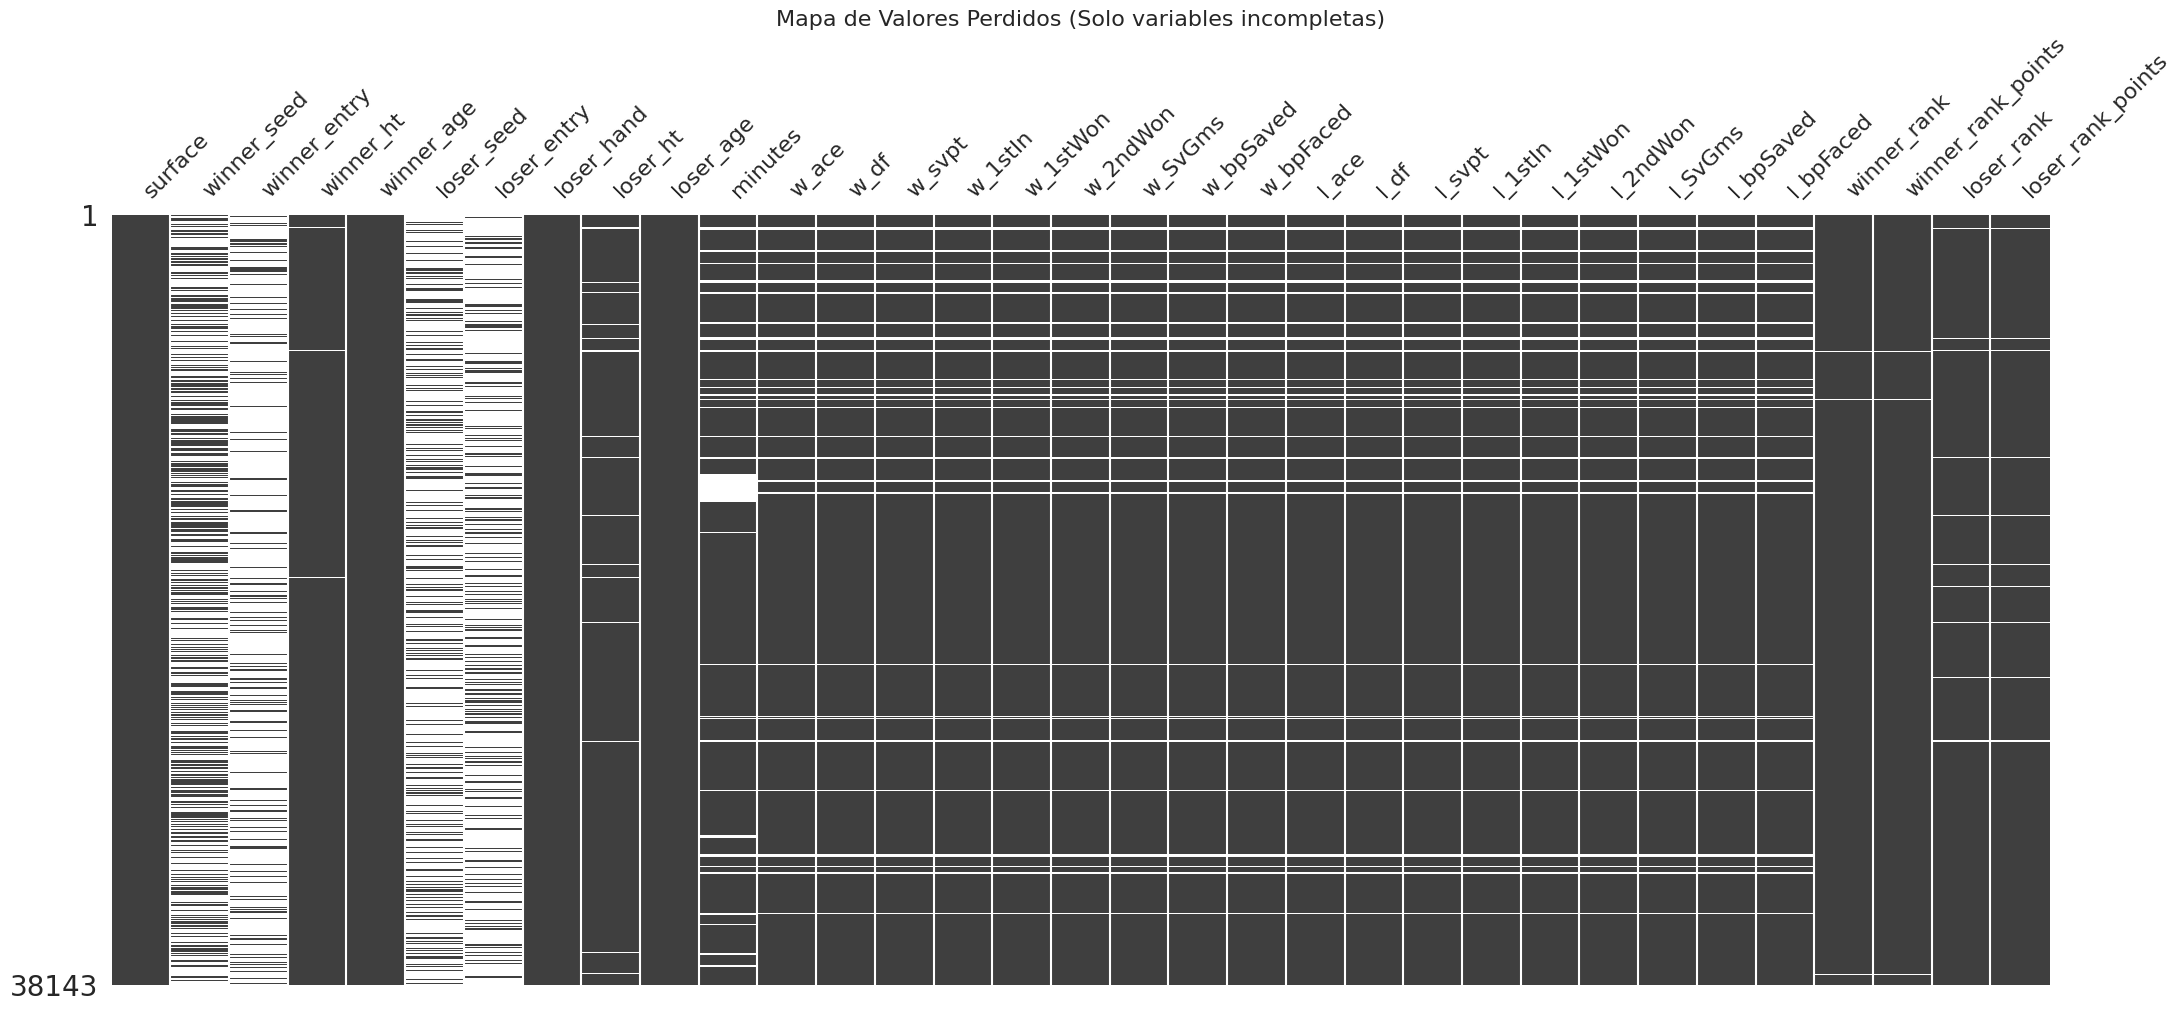

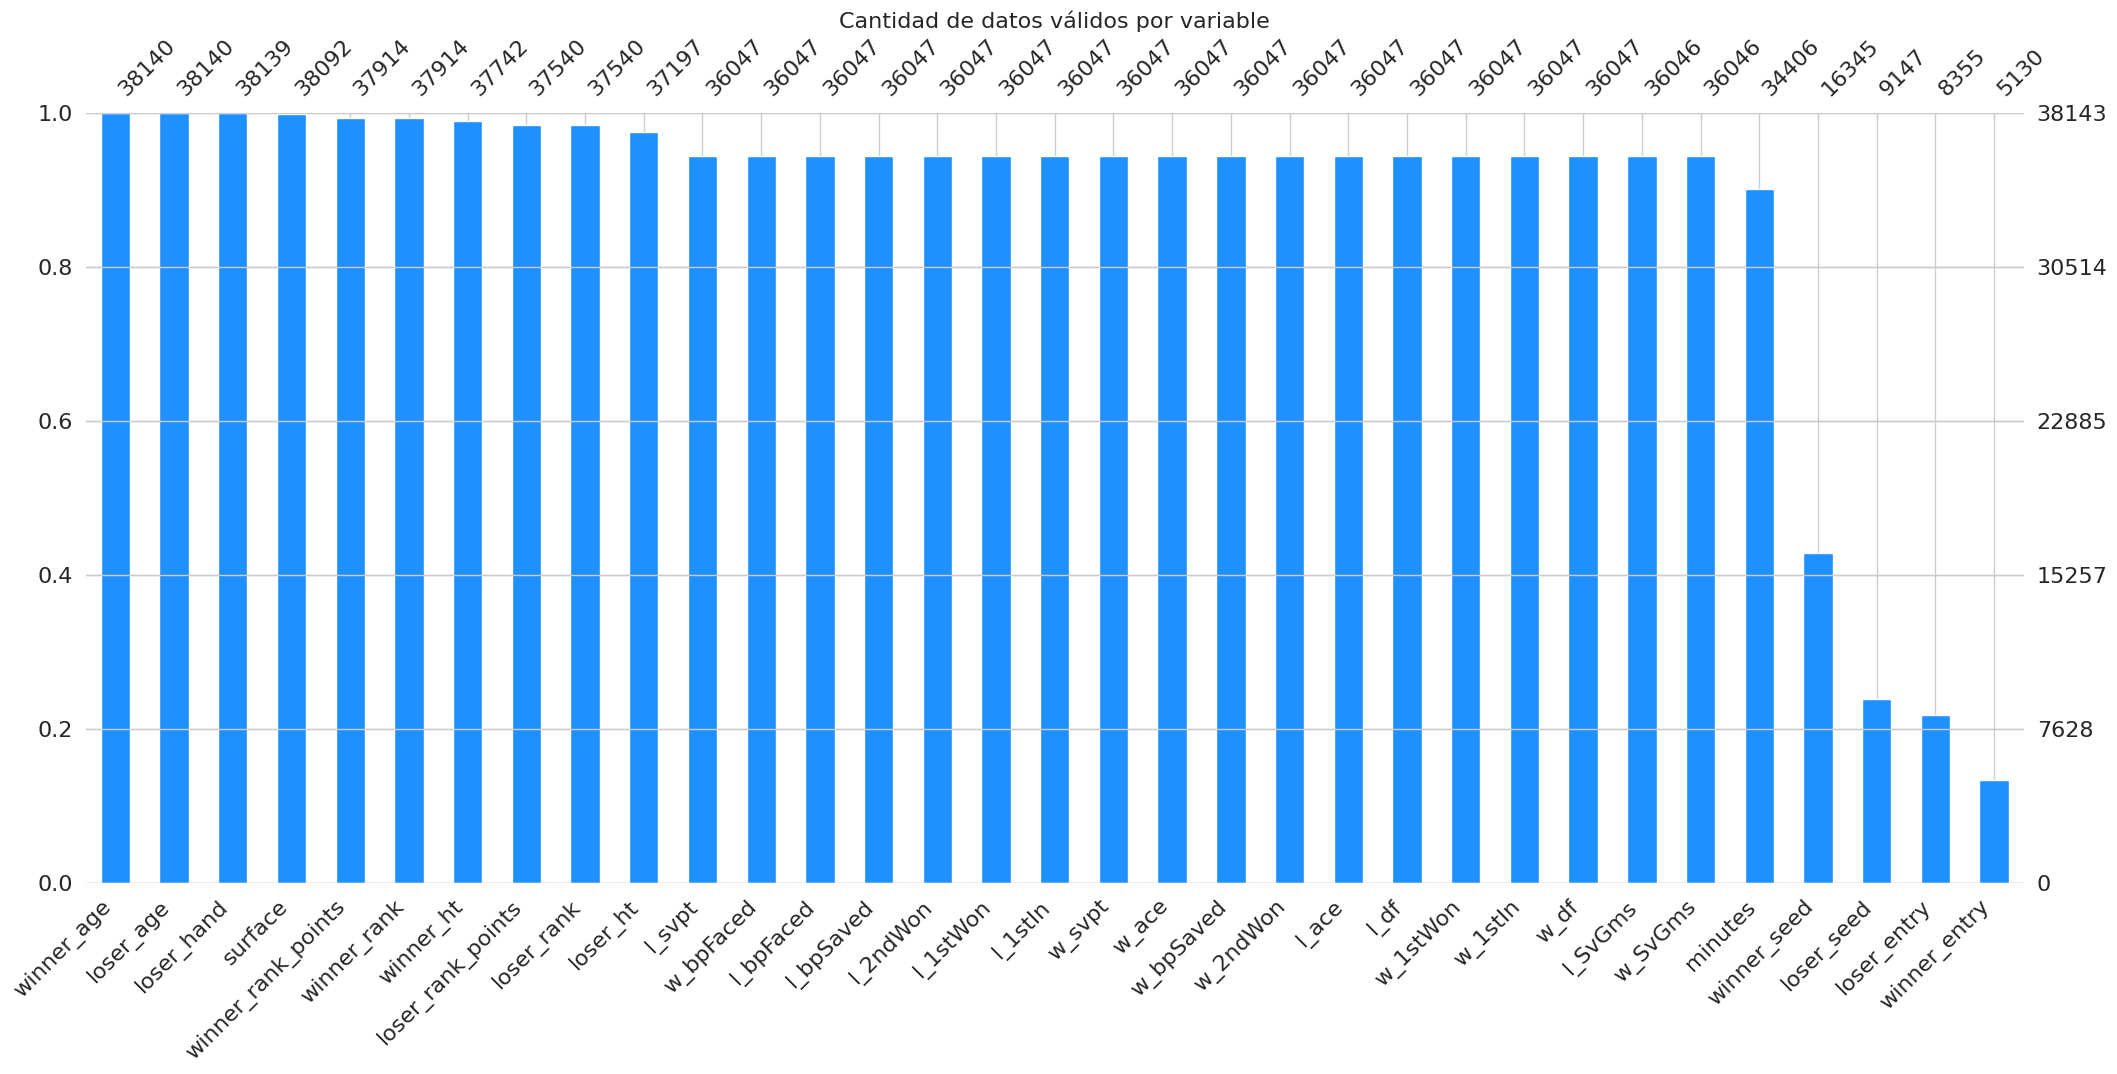

In [19]:
import missingno as msno
import matplotlib.pyplot as plt

# Identificamos las columnas que tienen nulos
cols_con_nulos = tennis.columns[tennis.isna().any()].tolist()

# Visualizaciones de valores perdidos
msno.matrix(tennis[cols_con_nulos], labels=True, sparkline=False)
plt.title("Mapa de Valores Perdidos (Solo variables incompletas)", fontsize=16)
plt.show();

msno.bar(tennis[cols_con_nulos], sort='descending', color='dodgerblue')
plt.title("Cantidad de datos válidos por variable", fontsize=16)
plt.show();

No nos queda otra, que tratar cada una de las variables una por una.

### B.3-Paso 1. Edad

In [20]:
# 1. Identificar jugadores con edad faltante (Winner o Loser)
nulos_w = tennis[tennis['winner_age'].isna()]['winner_name']
nulos_l = tennis[tennis['loser_age'].isna()]['loser_name']

# Unimos las dos listas y sacamos los únicos
jugadores_sin_edad = pd.concat([nulos_w, nulos_l]).unique()

print(f"Hay {len(jugadores_sin_edad)} jugadores sin edad.")
print("Lista de jugadores para buscar en Google:")
for jugador in jugadores_sin_edad:
    print(f"- {jugador}")

Hay 4 jugadores sin edad.
Lista de jugadores para buscar en Google:
- Ari Fahresi
- Luis Carlos Alvarez Valdes
- Diego Duran
- Hamza Karmoussi



* **Ari Fahresi:** August 2, 2002 [Link](https://www.tennisexplorer.com/player/fahresi/#:~:text=Country%3A%20Indonesia,Plays%3A%20right)
* **Luis Carlos Álvarez Valdés:** September 3, 2004 [Link](https://www.atptour.com/en/players/diego-duran/d0fo/overview#:~:text=Personal%20details,(2004%2F12%2F10))
* **Diego Durán:** December 10, 2004 [Link](https://www.tennisexplorer.com/player/duran-fd3b3/#:~:text=Diego%20(2004)%20Duran%20%2D%20Tennis,Plays%3A%20right)
* **Hamza Karmoussi:** November 26, 1993 [Link](https://www.atptour.com/en/players/hamza-karmoussi/ke25/overview#:~:text=Personal%20details,(1993%2F11%2F26))

In [21]:
# Diccionario con las fechas de nacimiento reales
fechas_nacimiento = {
    'Ari Fahresi': '2002-08-02',
    'Luis Carlos Alvarez Valdes': '2004-09-03', 
    'Diego Duran': '2004-12-10',                
    'Hamza Karmoussi': '1993-11-26'
}

print("Calculando edades exactas para los jugadores sin datos...")

count = 0
for nombre, fecha_nac in fechas_nacimiento.items():
    # Convertimos la fecha de nacimiento a datetime
    dob = pd.to_datetime(fecha_nac)
    
    # 1. Corregir donde aparece como WINNER
    mask_w = tennis['winner_name'].str.contains(nombre, case=False, regex=False)
    if mask_w.sum() > 0:
        tennis.loc[mask_w, 'winner_age'] = (tennis.loc[mask_w, 'tourney_date'] - dob).dt.days / 365.25
        count += mask_w.sum()
    
    # 2. Corregir donde aparece como LOSER
    mask_l = tennis['loser_name'].str.contains(nombre, case=False, regex=False)
    if mask_l.sum() > 0:
        tennis.loc[mask_l, 'loser_age'] = (tennis.loc[mask_l, 'tourney_date'] - dob).dt.days / 365.25
        count += mask_l.sum()

print(f"Se han calculado {count} edades exactas.")

# Por si acaso ha quedado algún caso suelto, rellenamos el resto con la media para que no queden NaNs que rompan el modelo.
media_edad = pd.concat([tennis['winner_age'], tennis['loser_age']]).mean()
nulos_restantes = tennis['winner_age'].isna().sum() + tennis['loser_age'].isna().sum()

if nulos_restantes > 0:
    tennis['winner_age'] = tennis['winner_age'].fillna(media_edad)
    tennis['loser_age'] = tennis['loser_age'].fillna(media_edad)
    print(f"Quedaban {nulos_restantes} registros sin edad. Se han rellenado con la media global ({media_edad:.2f}).")
else:
    print("Todos las edades están completas. 0 Nulos.")

Calculando edades exactas para los jugadores sin datos...
Se han calculado 6 edades exactas.
Todos las edades están completas. 0 Nulos.


---

### B.3-Paso 2. Mano.

In [22]:
# Miramos los NaNs (Vacíos)
filas_nulas = tennis[tennis['loser_hand'].isna()]

print(f"Se encontraron {len(filas_nulas)} filas con NaN en loser_hand")
if len(filas_nulas) > 0:
    display(filas_nulas[['tourney_date', 'loser_name', 'loser_id', 'loser_hand']])
    nombres_nan = filas_nulas['loser_name'].unique()
    print(f"\nJugadores con NaN: {nombres_nan}")

# Miramos los 'U' (Unknown)
filas_unknown = tennis[tennis['loser_hand'] == 'U']
print(f"\nSe encontraron {len(filas_unknown)} filas con etiqueta 'U'")

Se encontraron 4 filas con NaN en loser_hand


tourney_date           loser_name  loser_id loser_hand
11974   2015-03-06           Nour Nehme    145022        NaN
12023   2015-03-06          Maxim Bulat    145023        NaN
13188   2015-07-17          Maxim Bulat    145023        NaN
24846   2019-09-13  Sebastian Dominguez    209238        NaN


Jugadores con NaN: ['Nour Nehme' 'Maxim Bulat' 'Sebastian Dominguez']

Se encontraron 273 filas con etiqueta 'U'


Hemos buscado por internet y los 3 son diestros. Lo modificaremos de manera manual.

Nulos reales (NaN) restantes: 0

--- Variable Hand corregida ---
Valores únicos: ['R' 'L' 'U']
Total Nulos: 0


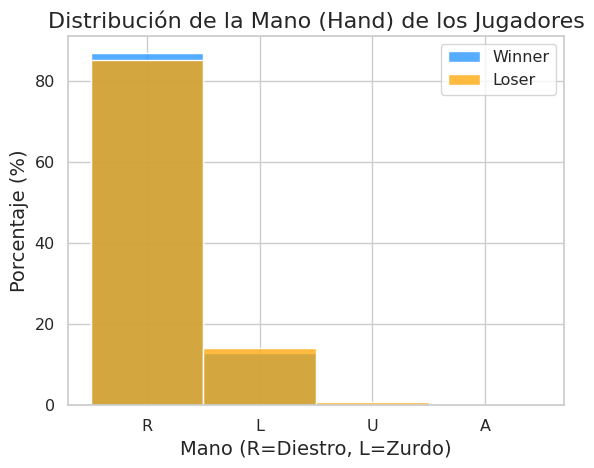

In [23]:
# Diccionario con los datos reales que hemos encontrado
manos_rescatadas = {
    'Nour Nehme': 'R',
    'Maxim Bulat': 'R',
    'Sebastian Dominguez': 'R'
}

# Aplicamos las correcciones manuales a los NaNs
for nombre, mano in manos_rescatadas.items():
    # Corregimos tanto en winner como en loser por si acaso
    tennis.loc[tennis['winner_name'] == nombre, 'winner_hand'] = mano
    tennis.loc[tennis['loser_name'] == nombre, 'loser_hand'] = mano

# Verificamos si queda algún NaN real (debería ser 0)
nulos_reales = tennis['winner_hand'].isna().sum() + tennis['loser_hand'].isna().sum()
print(f"Nulos reales (NaN) restantes: {nulos_reales}")

# Ahora solo deberíamos tener 'R' y 'L' (y quizás 'A' si había alguno)
print("\n--- Variable Hand corregida ---")
print(f"Valores únicos: {tennis['loser_hand'].unique()}")
print(f"Total Nulos: {tennis[['winner_hand', 'loser_hand']].isna().sum().sum()}")

sns.histplot(tennis['winner_hand'], color='dodgerblue', label='Winner', kde=False, stat='percent', discrete=True)
sns.histplot(tennis['loser_hand'], color='orange', label='Loser', kde=False, stat='percent', discrete=True)
plt.title("Distribución de la Mano (Hand) de los Jugadores", fontsize=16)
plt.xlabel("Mano (R=Diestro, L=Zurdo)", fontsize=14)
plt.ylabel("Porcentaje (%)", fontsize=14)
plt.legend()
plt.show();

Con el objetivo de simplificar la práctica las variables unknown las pasaremos a diestros.

In [24]:
# Reemplazamos tanto 'U' (Unknown) como los NaN por 'R' (Right/Diestro)
tennis['winner_hand'] = tennis['winner_hand'].replace('U', 'R').fillna('R')
tennis['loser_hand'] = tennis['loser_hand'].replace('U', 'R').fillna('R')

# --- VERIFICACIÓN ---
print("Valores únicos actuales:")
print(f"Winner Hand: {tennis['winner_hand'].unique()}")
print(f"Loser Hand: {tennis['loser_hand'].unique()}")

Valores únicos actuales:
Winner Hand: ['R' 'L' 'A']
Loser Hand: ['R' 'L']


Observamos que hay casos de jugadores ambidiestrsos, al haber tan pocos casos los consideraremos R (diestros).

In [25]:
tennis['winner_hand'] = tennis['winner_hand'].replace('A').fillna('R')
print(f"Winner Hand: {tennis['winner_hand'].unique()}")

Winner Hand: ['R' 'L']


---

### B.3-Paso 4. Seeds y entries.

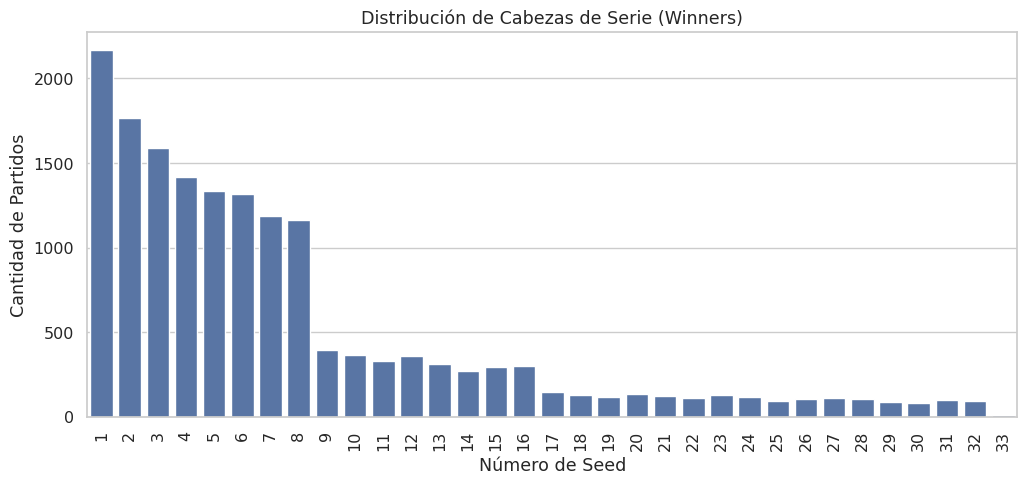

Seed máximo encontrado: 33.0


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertimos a numérico por si acaso hay texto mezclado, forzando errores a NaN
tennis['winner_seed'] = pd.to_numeric(tennis['winner_seed'], errors='coerce')

# Gráfico de distribución de Seeds
plt.figure(figsize=(12, 5))
sns.countplot(x=tennis['winner_seed'].dropna().astype(int))
plt.title('Distribución de Cabezas de Serie (Winners)')
plt.xlabel('Número de Seed')
plt.ylabel('Cantidad de Partidos')
plt.xticks(rotation=90)
plt.show()

print(f"Seed máximo encontrado: {tennis['winner_seed'].max()}")

In [27]:
# SEEDS: Usamos 100 para indicar "Peor que el último seed (32)"
val_no_seed = 100

tennis['winner_seed'] = tennis['winner_seed'].fillna(val_no_seed)
tennis['loser_seed'] = tennis['loser_seed'].fillna(val_no_seed)

# ENTRIES: Los nulos son 'Direct Acceptance' (Entrada directa por ranking)
tennis['winner_entry'] = tennis['winner_entry'].fillna('DA')
tennis['loser_entry'] = tennis['loser_entry'].fillna('DA')

# Verificación
print("Imputación realizada.")
print(f"Nulos restantes en Seeds: {tennis['winner_seed'].isna().sum()}")
print(f"Nulos restantes en Entries: {tennis['winner_entry'].isna().sum()}")
print(f"Valores únicos en Entry: {tennis['winner_entry'].unique()}")

Imputación realizada.
Nulos restantes en Seeds: 0
Nulos restantes en Entries: 0
Valores únicos en Entry: ['DA' 'Q' 'WC' 'LL' 'PR' 'SE' 'ALT' 'Alt' 'ITF' 'UP' 'W']


In [28]:
#ESTANDARIZACIÓN Y CORRECCIÓN DE ENTRIES

# Limpieza básica
tennis['winner_entry'] = tennis['winner_entry'].str.upper().str.strip()
tennis['loser_entry'] = tennis['loser_entry'].str.upper().str.strip()

#Corrección de errores tipográficos específicos
correcciones = {'W': 'WC'}

tennis['winner_entry'] = tennis['winner_entry'].replace(correcciones)
tennis['loser_entry'] = tennis['loser_entry'].replace(correcciones)

#VERIFICACIÓN
print("Correcciones aplicadas: Mayúsculas + Unificación W->WC.")
print(f"Valores únicos en Winner Entry: {tennis['winner_entry'].unique()}")
print(f"Valores únicos en Loser Entry:  {tennis['loser_entry'].unique()}")

Correcciones aplicadas: Mayúsculas + Unificación W->WC.
Valores únicos en Winner Entry: ['DA' 'Q' 'WC' 'LL' 'PR' 'SE' 'ALT' 'ITF' 'UP']
Valores únicos en Loser Entry:  ['Q' 'DA' 'WC' 'LL' 'PR' 'SE' 'ALT' 'ITF' 'UP']


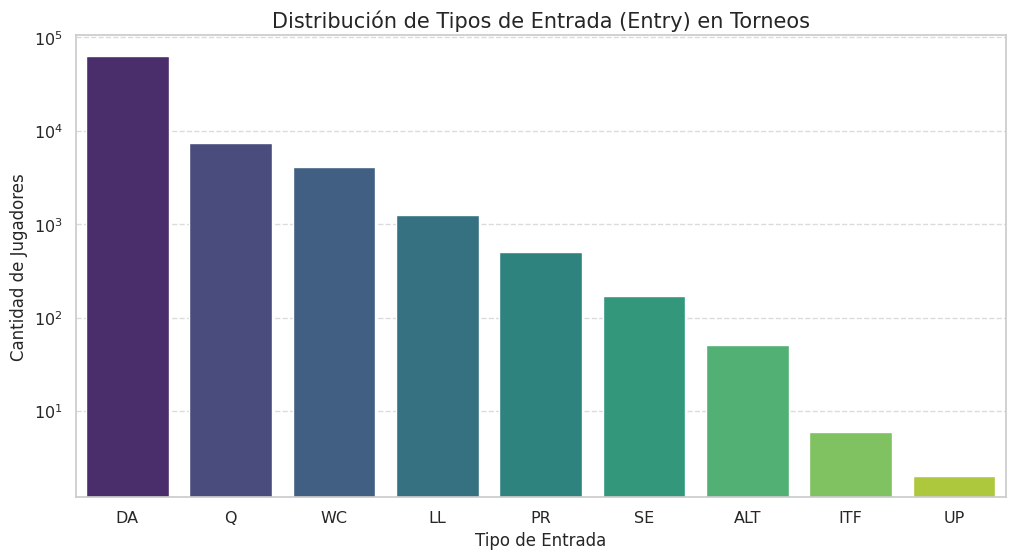

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unimos ganadores y perdedores para ver la distribución global del circuito
todas_las_entradas = pd.concat([tennis['winner_entry'], tennis['loser_entry']])

plt.figure(figsize=(12, 6))
sns.countplot(x=todas_las_entradas, order=todas_las_entradas.value_counts().index, palette='viridis')

plt.title('Distribución de Tipos de Entrada (Entry) en Torneos', fontsize=15)
plt.xlabel('Tipo de Entrada', fontsize=12)
plt.ylabel('Cantidad de Jugadores', fontsize=12)
plt.yscale('log') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show();


* **DA:** Direct Acceptance (Ranking directo).
* **Q:** Qualifier (Viene de la fase previa).
* **WC:** Wild Card (Invitado).
* **LL:** Lucky Loser (Perdió la previa pero entró por baja de otro).
* **PR:** Protected Ranking (Vuelve de lesión con ranking congelado).
* **SE:** Special Exempt.
* **ALT:** Alternate (Suplente).
* **ITF:** International Tennis Federation (invited by them).
* **UP:** Unranked player.


---

### B.3-Paso 5. Rankings y puntos.

In [30]:
# Definimos el valor para "Sin Ranking"
# Usamos 3000 porque es peor que cualquier ranking profesional normal (aprox 2000).
rank_bajo = 3000

#Imputamos Rankings
tennis['winner_rank'] = tennis['winner_rank'].fillna(rank_bajo)
tennis['loser_rank'] = tennis['loser_rank'].fillna(rank_bajo)

#Imputamos Puntos (Si no hay ranking, hay 0 puntos)
tennis['winner_rank_points'] = tennis['winner_rank_points'].fillna(0)
tennis['loser_rank_points'] = tennis['loser_rank_points'].fillna(0)

# VERIFICACIÓN
print("Rankings y Puntos imputados.")
print(f"Nulos restantes en Rank (W/L): {tennis['winner_rank'].isna().sum()} / {tennis['loser_rank'].isna().sum()}")
print(f"Nulos restantes en Points (W/L): {tennis['winner_rank_points'].isna().sum()} / {tennis['loser_rank_points'].isna().sum()}")

Rankings y Puntos imputados.
Nulos restantes en Rank (W/L): 0 / 0
Nulos restantes en Points (W/L): 0 / 0


---

### B.3-Paso 6. Alturas.

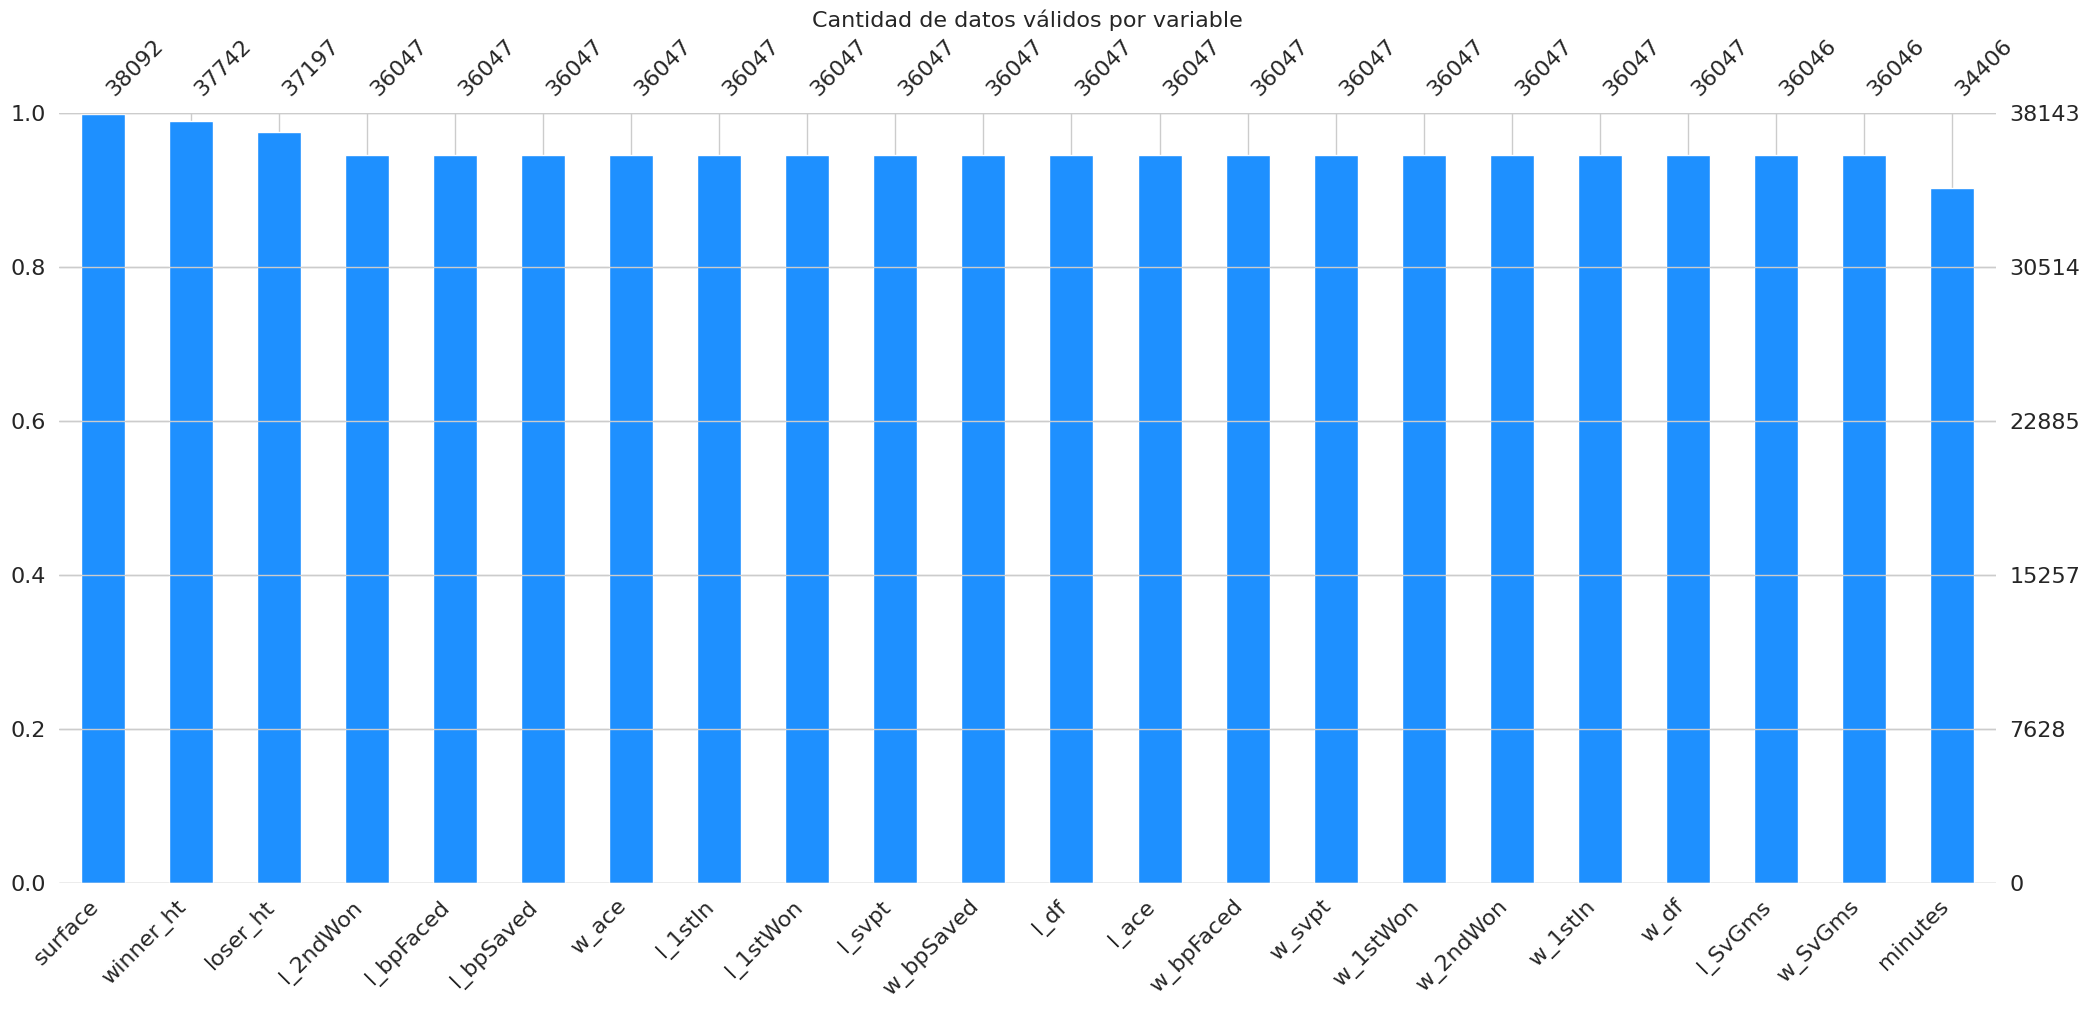

In [31]:
import missingno as msno
import matplotlib.pyplot as plt

# Identificamos las columnas que tienen nulos
cols_con_nulos = tennis.columns[tennis.isna().any()].tolist()

# Gráfico de barras de las variables con nulos
msno.bar(tennis[cols_con_nulos], sort='descending', color='dodgerblue')
plt.title("Cantidad de datos válidos por variable", fontsize=16)
plt.show()

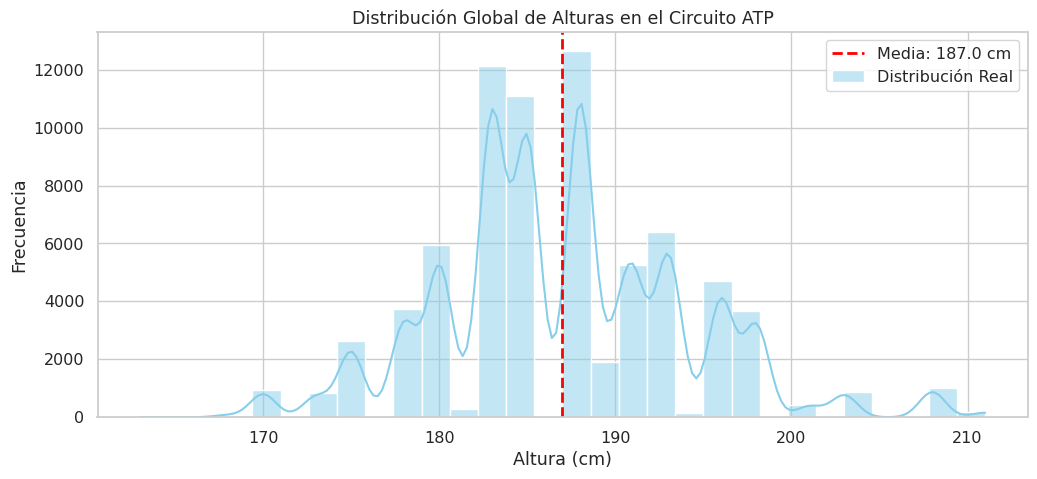

ANÁLISIS DE VALORES FALTANTES:
Ranking promedio de jugadores CON altura conocida: 77
Ranking promedio de jugadores SIN altura (Nulos): 1502


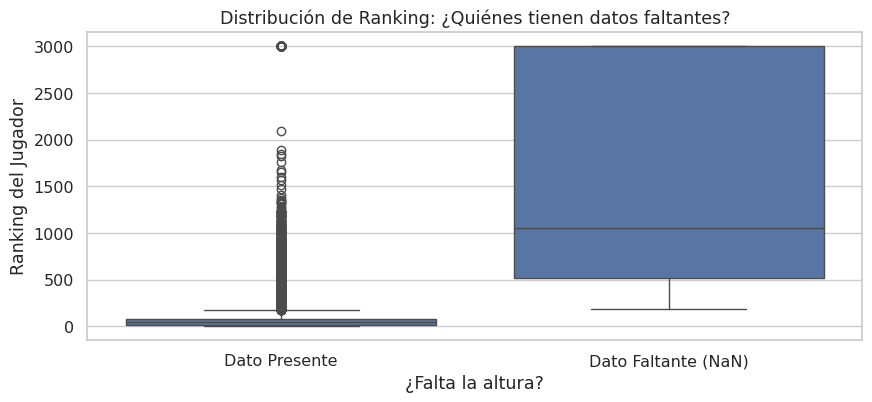

In [32]:
# VISUALIZACIÓN DE LA DISTRIBUCIÓN (Winner + Loser)
# Unimos ganadores y perdedores para ver la "población total" de tenistas
all_heights = pd.concat([tennis['winner_ht'], tennis['loser_ht']])
mean_height = all_heights.mean()

plt.figure(figsize=(12, 5))

# Histograma y densidad
sns.histplot(all_heights, kde=True, bins=30, color='skyblue', label='Distribución Real')
# Línea de la media
plt.axvline(mean_height, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_height:.1f} cm')

plt.title('Distribución Global de Alturas en el Circuito ATP')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show();

# Creamos una columna temporal para identificar si falta la altura
# Usamos winner para el ejemplo, pero aplica a ambos
tennis['missing_ht_w'] = tennis['winner_ht'].isna()

# Calculamos el ranking promedio de los que TIENEN altura vs los que NO
rank_con_dato = tennis[tennis['missing_ht_w'] == False]['winner_rank'].mean()
rank_sin_dato = tennis[tennis['missing_ht_w'] == True]['winner_rank'].mean()

print("ANÁLISIS DE VALORES FALTANTES:")
print(f"Ranking promedio de jugadores CON altura conocida: {rank_con_dato:.0f}")
print(f"Ranking promedio de jugadores SIN altura (Nulos): {rank_sin_dato:.0f}")

# Visualización por Ranking
plt.figure(figsize=(10, 4))
sns.boxplot(x='missing_ht_w', y='winner_rank', data=tennis)
plt.title('Distribución de Ranking: ¿Quiénes tienen datos faltantes?')
plt.xlabel('¿Falta la altura?')
plt.ylabel('Ranking del Jugador')
plt.xticks([0, 1], ['Dato Presente', 'Dato Faltante (NaN)'])
plt.show()

# Limpieza auxiliar
tennis.drop(columns=['missing_ht_w'], inplace=True)

In [33]:
w_sin_altura = tennis[tennis['winner_ht'].isna()]['winner_name']
l_sin_altura = tennis[tennis['loser_ht'].isna()]['loser_name']

# Juntamos ambas listas y nos quedamos solo con los nombres ÚNICOS
jugadores_sin_altura = pd.concat([w_sin_altura, l_sin_altura]).unique()
jugadores_sin_altura.sort() # Los ordenamos alfabéticamente para verlos mejor

print(f"Número total de jugadores únicos sin altura: {len(jugadores_sin_altura)}")
print("\nLista de jugadores:")
print(jugadores_sin_altura)

Número total de jugadores únicos sin altura: 440

Lista de jugadores:
['Abdulhameed Alshatti' 'Abdulhamid Mubarak' 'Abdullah Maqdas'
 'Abdulrahman Alawadhi' 'Adam Hornby' 'Adam Kellner'
 'Aditya Hari Sasongko' 'Adrien Bossel' 'Ainius Sabaliauskas'
 'Aissa Benchakroun' 'Alberto Emmanuel Alvarado Larin' 'Alberto Lim'
 'Alen Avidzba' 'Alex Diaz' 'Alex Fairbanks' 'Alex Llompart'
 'Alexander Blom' 'Alexandros Jakupovic' 'Alexios Halebian'
 'Alexis Klegou' 'Ali Ghareeb' 'Amer Naow' 'Amir Hossein Badi'
 'Amir Milushev' 'Anas Fattar' 'Andis Juska' 'Ando Rasolomalala'
 'Andre Gaspar Murta' 'Andrea Basso' 'Andreas Bjerrehus' 'Andrei Ciumac'
 'Andrei Daescu' 'Andrei Gorban' 'Andrei Soltoianu'
 'Andres Artunedo Martinavarro' 'Andres Bucaro' 'Andres Weisskopf'
 'Andrey Kumantsov' 'Anil Yuksel' 'Anis Ghorbel' 'Anoosha Shahgholi'
 'Anthony Jackie Tang' 'Anthony Marshall' 'Anthony Susanto'
 'Antso Rakotondramanga' 'Aqeel Khan' 'Ari Fahresi'
 'Ariez Elyaas Deen Heshaam' 'Aristotelis Thanos' 'Arturs Laz

In [34]:
# SOLUCIÓN AVANZADA: IMPUTACIÓN ALEATORIA (Probabilística)

# Analizamos la distribución actual
todos_con_altura = pd.concat([tennis['winner_ht'].dropna(), tennis['loser_ht'].dropna()])
media = todos_con_altura.mean()
std = todos_con_altura.std() # Cuánto varían los datos

print(f"Parámetros de la distribución real -> Media: {media:.2f} cm | Desviación: {std:.2f} cm")

# Función para rellenar huecos generando datos que parezcan reales
def imputar_aleatorio(columna, mu, sigma):
    n_nulos = columna.isna().sum()
    if n_nulos > 0:
        valores_generados = np.random.normal(loc=mu, scale=sigma, size=n_nulos)
        valores_generados = np.round(valores_generados, 0)
        columna_rellena = columna.copy()
        columna_rellena.loc[columna.isna()] = valores_generados
        return columna_rellena
    else:
        return columna

# Fijamos semilla para reproducibilidad
np.random.seed(42) 

tennis['winner_ht'] = imputar_aleatorio(tennis['winner_ht'], media, std)
tennis['loser_ht'] = imputar_aleatorio(tennis['loser_ht'], media, std)

# Tratamiento de MINUTOS
media_minutos = tennis['minutes'].mean()
tennis['minutes'] = tennis['minutes'].fillna(media_minutos)
print(f"Minutos imputados con la media ({media_minutos:.1f} min).")

# VERIFICACIÓN FINAL
nulos_finales = tennis[['winner_ht', 'loser_ht', 'minutes']].isna().sum().sum()
print(f"\nNulos restantes en Físicas/Tiempo: {nulos_finales} (Debe ser 0)")

Parámetros de la distribución real -> Media: 186.99 cm | Desviación: 7.05 cm
Minutos imputados con la media (112.5 min).

Nulos restantes en Físicas/Tiempo: 0 (Debe ser 0)


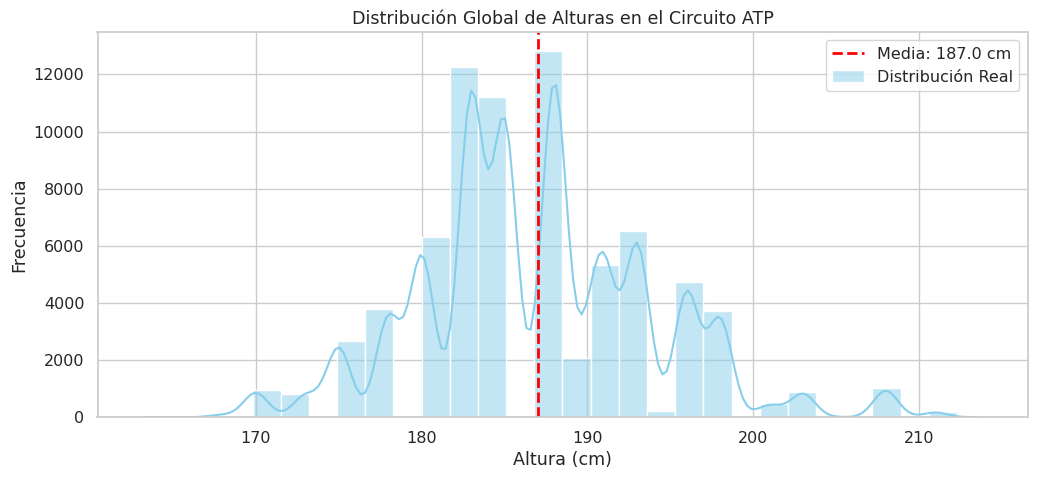

In [35]:
# VISUALIZACIÓN DE LA DISTRIBUCIÓN (Winner + Loser)

all_heights = pd.concat([tennis['winner_ht'], tennis['loser_ht']])
mean_height = all_heights.mean()

plt.figure(figsize=(12, 5))

# Histograma y densidad
sns.histplot(all_heights, kde=True, bins=30, color='skyblue', label='Distribución Real')
# Línea de la media
plt.axvline(mean_height, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_height:.1f} cm')

plt.title('Distribución Global de Alturas en el Circuito ATP')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

---

### B.3-Paso 7. Surfaces y aces.

In [36]:
# Eliminamos partidos sin superficie conocida (muy pocos)
tennis.dropna(subset=['surface'], inplace=True)

# Eliminamos partidos sin estadísticas (usamos w_ace como referencia)
tennis.dropna(subset=['w_ace'], inplace=True)

tennis.reset_index(drop=True, inplace=True)


print(f"Filas finales en el dataset: {len(tennis)}")
total_nulos = tennis.isna().sum().sum()

if total_nulos == 0:
    print("\nDataset completamente limpio (0 nulos).")
else:
    print(f"\nAún quedan {total_nulos} nulos.")

Filas finales en el dataset: 36047

Aún quedan 2 nulos.


In [37]:
#Ejecutamos el siguiente comando para ver dónde quedan valores nulos:
tennis.isna().sum()[tennis.isna().sum() > 0]

w_SvGms    1
l_SvGms    1
dtype: int64

In [38]:
fila_problem = tennis[tennis['w_SvGms'].isna() | tennis['l_SvGms'].isna()]

if len(fila_problem) > 0:
    print("Partidos problemáticos encontrados:")
    display(fila_problem[['tourney_date', 'winner_name', 'loser_name', 'score', 'w_SvGms', 'l_SvGms']])

tennis.dropna(subset=['w_SvGms', 'l_SvGms'], inplace=True)
tennis.reset_index(drop=True, inplace=True)

nulos_finales = tennis.isna().sum().sum()
print(f"\nFilas restantes: {len(tennis)}")
print(f"Nulos totales: {nulos_finales}")

if nulos_finales == 0:
    print("\nDatos completamente limpios.")

Partidos problemáticos encontrados:


tourney_date  winner_name           loser_name    score  w_SvGms  \
35139   2024-07-29  Casper Ruud  Francisco Cerundolo  6-3 6-4      NaN   

       l_SvGms  
35139      NaN


Filas restantes: 36046
Nulos totales: 0

Datos completamente limpios.


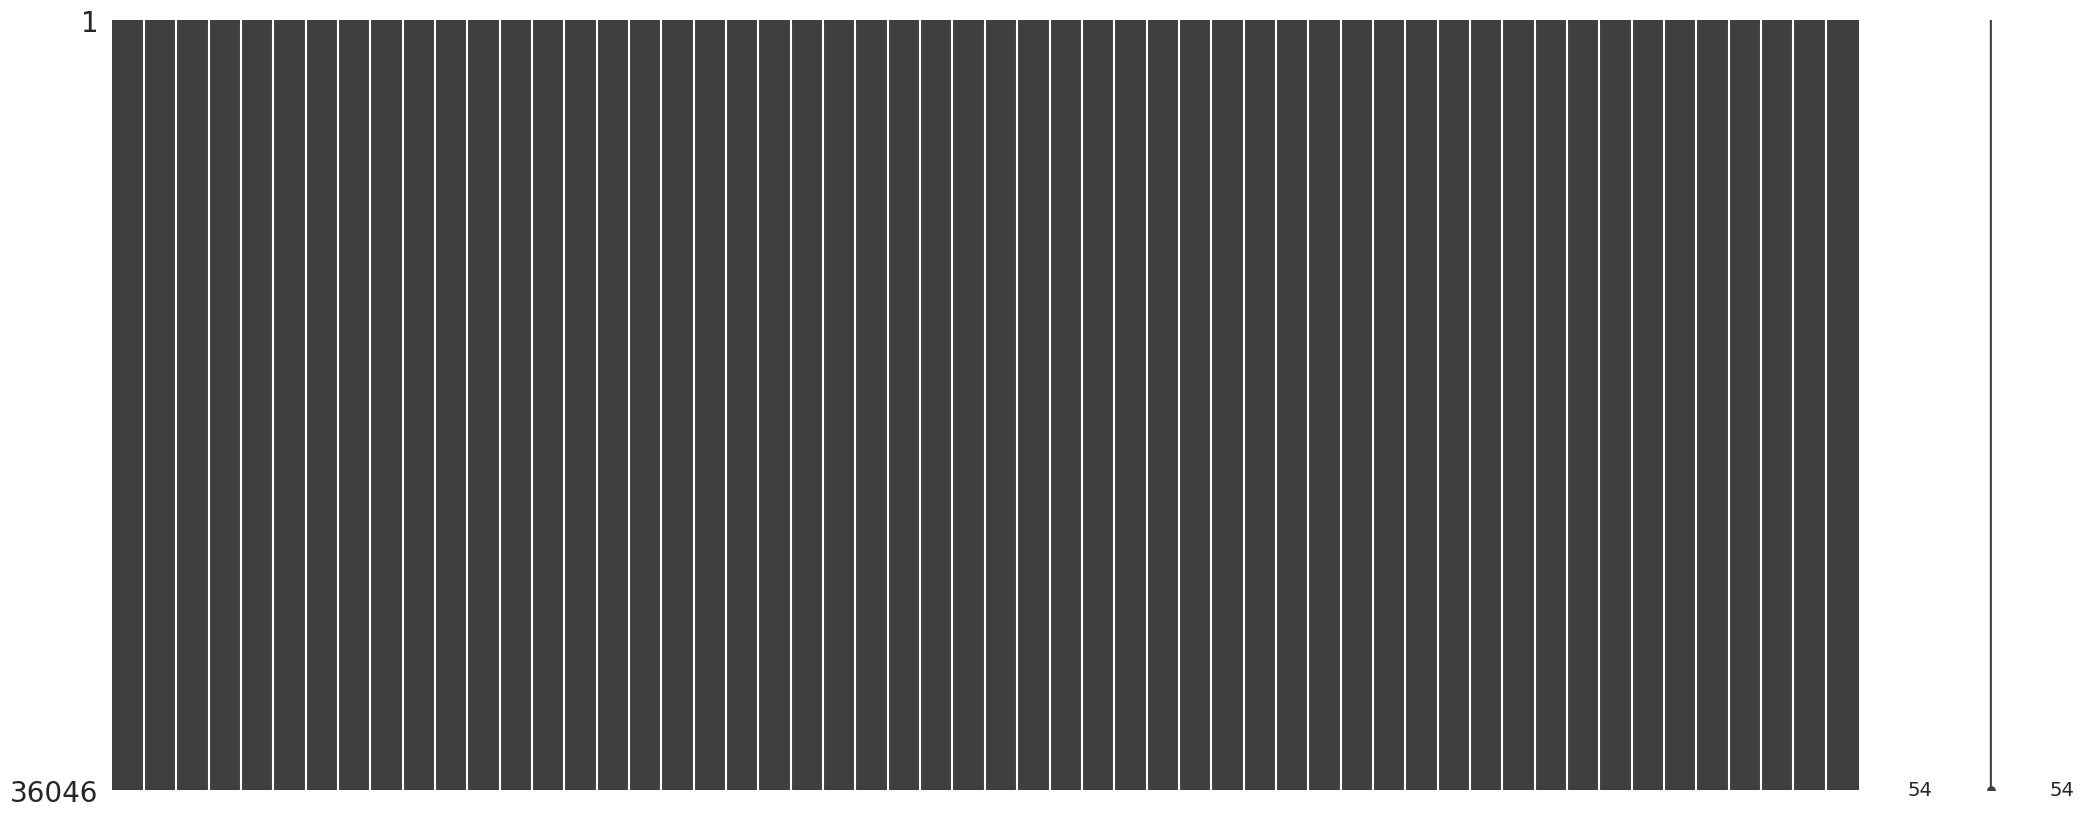

In [39]:
msno.matrix(tennis);

---
---

## B.4-Feature engineering

Este es el apartado más importante. Aquí creamos variables que le dan más información al modelo para mejorar las predicciones.

Veamos qué tenemos actualmente:


In [40]:
tennis.shape

(36046, 54)

In [41]:
tennis.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'year', 'month', 'day', 'month_name', 'tourney_points'],
      dtype='object')>

## B.4.1-Head-to-Head (H2H)
Historial de enfrentamientos previos entre los dos jugadores:

In [42]:
def agregar_h2h(df_original):
    """
    Calcula el historial de enfrentamientos previos (H2H) entre cada par de jugadores.
    """
    print("Calculando Head-to-Head (H2H)...")
    
    # Ordenar por fecha para no "viajar al futuro"
    df = df_original.sort_values(['tourney_date', 'match_num']).copy()
    
    # Diccionario para guardar victorias: (ganador_id, perdedor_id) -> num_victorias
    wins_registry = {}
    
    w_h2h_past = []
    l_h2h_past = []
    
    # Iteramos usando arrays de numpy (más rápido que iterrows)
    winner_ids = df['winner_id'].values
    loser_ids = df['loser_id'].values
    
    for w_id, l_id in zip(winner_ids, loser_ids):
        
        # Consultamos victorias previas
        prior_wins_w = wins_registry.get((w_id, l_id), 0)
        prior_wins_l = wins_registry.get((l_id, w_id), 0)
        
        # Guardamos el estado ANTES del partido
        w_h2h_past.append(prior_wins_w)
        l_h2h_past.append(prior_wins_l)
        
        # Actualizamos: el winner suma una victoria más
        wins_registry[(w_id, l_id)] = prior_wins_w + 1
    
    df['w_h2h'] = w_h2h_past
    df['l_h2h'] = l_h2h_past
    
    print("H2H calculado")
    return df

tennis = agregar_h2h(tennis)

Calculando Head-to-Head (H2H)...
H2H calculado


## B.4.2-¿Es cabeza de serie?


In [43]:
def agregar_is_seeded(df):
    df['w_is_seeded'] = np.where(df['winner_seed'].notna(), 1, 0)
    df['l_is_seeded'] = np.where(df['loser_seed'].notna(), 1, 0)
    print("Variable 'is_seeded' agregada")
    return df

tennis = agregar_is_seeded(tennis)

Variable 'is_seeded' agregada


## B.4.3-¿Es su primer partido registrado?

Problema: nuestro dataset empieza en 2011. Para jugadores veteranos como Federer que ya estaban en el circuito, no queremos marcarlos como "novatos" solo porque es su primera aparición en nuestros datos.

Solución: solo marcamos `is_first_match = 1` si es el primer partido **y además** tiene ranking > 200 (o sin ranking). Los veteranos que aparecen por primera vez pero con buen ranking se marcan como 0.


In [44]:
def agregar_indicador_primer_partido_inteligente(df):
    print("Identificando novatos vs veteranos...")
    
    df_w = df[['tourney_date', 'match_num', 'winner_id', 'winner_rank']].copy()
    df_w.columns = ['date', 'match_num', 'player_id', 'rank']
    
    df_l = df[['tourney_date', 'match_num', 'loser_id', 'loser_rank']].copy()
    df_l.columns = ['date', 'match_num', 'player_id', 'rank']
    
    df_long = pd.concat([df_w, df_l]).sort_values(['date', 'match_num'])
    
    # Contamos el número de partidos previos por jugador
    df_long['match_count'] = df_long.groupby('player_id').cumcount()
    
    RANK_THRESHOLD = 200
    cond_first_time = (df_long['match_count'] == 0)
    cond_bad_rank = (df_long['rank'].fillna(9999) > RANK_THRESHOLD)
    
    df_long['is_first_match'] = np.where(cond_first_time & cond_bad_rank, 1, 0)
    
    veteranos_salvados = df_long[cond_first_time & ~cond_bad_rank]
    print(f"Veteranos detectados al inicio: {len(veteranos_salvados)}")

    # Merge de vuelta al formato original
    cols_to_merge = ['date', 'match_num', 'player_id', 'is_first_match']
    df_flags = df_long[cols_to_merge]
    
    df = df.merge(df_flags, 
                  left_on=['tourney_date', 'match_num', 'winner_id'], 
                  right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={'is_first_match': 'w_is_first_match'}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    df = df.merge(df_flags, 
                  left_on=['tourney_date', 'match_num', 'loser_id'], 
                  right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={'is_first_match': 'l_is_first_match'}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    print("Variable 'is_first_match' creada")
    return df

# Ejecutar
tennis = agregar_indicador_primer_partido_inteligente(tennis)

Identificando novatos vs veteranos...
Veteranos detectados al inicio: 281
Variable 'is_first_match' creada


### B.4.4: Forma reciente

Calculamos métricas de rendimiento para diferentes ventanas temporales:
- 1, 5, 10 últimos partidos
- Toda la carrera (lifetime)

Variables que calculamos:
- `win_rate`: % de victorias
- `ace_pct`: % de aces por punto de servicio
- `df_pct`: % de dobles faltas
- `1st_won_pct`: % de puntos ganados con primer servicio
- `bp_save_pct`: % de break points salvados
- `tb_rate`: Tiebreaks por set
- `tb_won_pct`: % de tiebreaks ganados

Para jugadores con pocos partidos aplicamos suavizado bayesiano con las medias globales.

---





In [45]:
import pandas as pd
import numpy as np
import re

# 1. PARSING (Crear variables de marcador)
def parse_match_stats(df):
    """Extrae número de sets y tiebreaks del score"""
    print("Parseando marcadores...")
    
    regex_sets = re.compile(r'\d+-\d+')
    
    def analyze_score(score):
        if not isinstance(score, str) or score == 'W/O' or pd.isna(score):
            return 0, 0, 0, 0 # n_sets, total_tb, w_tb, l_tb
            
        n_sets = len(regex_sets.findall(score))
        total_tb = score.count('(')
        
        if total_tb == 0:
            return n_sets, 0, 0, 0
            
        w_tb_won = score.count('7-6')
        l_tb_won = score.count('6-7')
        
        return n_sets, total_tb, w_tb_won, l_tb_won

    stats = [analyze_score(s) for s in df['score']]
    
    df['n_sets'] = [x[0] for x in stats]
    df['total_tb'] = [x[1] for x in stats]
    df['w_tb_won'] = [x[2] for x in stats]
    df['l_tb_won'] = [x[3] for x in stats]
    
    print("Variables de score creadas")
    return df

# 2.CÁLCULO DE FEATURES
def calcular_features_bayes_raw(df):
    n_inicial = df.shape[1]
    print(f"2. Calculando Métricas Históricas (Bayes)... (Variables iniciales: {n_inicial})")
    
    df['tourney_date'] = pd.to_datetime(df['tourney_date'])
    
    # Métricas a calcular: (numerador, denominador)     
    metrics_map = {
        'win_rate':    ('n_won', 'd_matches'),
        'ace_pct':     ('n_aces', 'd_svpt'),
        'df_pct':      ('n_df', 'd_svpt'),
        '1st_won_pct': ('n_1stWon', 'd_1stIn'),
        'bp_save_pct': ('n_bpSaved', 'd_bpFaced'),
        'tb_rate':     ('n_total_tb', 'd_sets'),
        'tb_won_pct':  ('n_tb_won', 'd_tb_count')
    }
    
    windows = [1, 5, 10] 
    
    # Preparar formato largo
    base_cols_w = ['tourney_date', 'match_num', 'winner_id', 'winner_rank', 
                   'w_ace', 'w_svpt', 'w_df', 'w_1stWon', 'w_1stIn', 'w_bpSaved', 'w_bpFaced',
                   'n_sets', 'total_tb', 'w_tb_won']
                   
    base_cols_l = ['tourney_date', 'match_num', 'loser_id', 'loser_rank', 
                   'l_ace', 'l_svpt', 'l_df', 'l_1stWon', 'l_1stIn', 'l_bpSaved', 'l_bpFaced',
                   'n_sets', 'total_tb', 'l_tb_won']

    df_w = df[base_cols_w].copy()
    df_w.columns = ['date', 'match_num', 'player_id', 'rank', 
                    'n_aces', 'd_svpt', 'n_df', 'n_1stWon', 'd_1stIn', 'n_bpSaved', 'd_bpFaced',
                    'd_sets', 'n_total_tb', 'n_tb_won']
    df_w['d_matches'] = 1; df_w['n_won'] = 1; df_w['d_tb_count'] = df_w['n_total_tb']

    df_l = df[base_cols_l].copy()
    df_l.columns = ['date', 'match_num', 'player_id', 'rank', 
                    'n_aces', 'd_svpt', 'n_df', 'n_1stWon', 'd_1stIn', 'n_bpSaved', 'd_bpFaced',
                    'd_sets', 'n_total_tb', 'n_tb_won']
    df_l['d_matches'] = 1; df_l['n_won'] = 0; df_l['d_tb_count'] = df_l['n_total_tb']

    df_long = pd.concat([df_w, df_l]).sort_values(['player_id', 'date', 'match_num'])
    
    # Marcar novatos
    df_long['cum_matches'] = df_long.groupby('player_id').cumcount()
    df_long['is_rookie'] = np.where((df_long['cum_matches'] == 0) & (df_long['rank'].fillna(999) > 200), 1, 0)

    # Calcular métricas globales
    global_stats = {}
    for name, (num, den) in metrics_map.items():
        total_num = df_long[num].sum()
        total_den = df_long[den].replace(0, np.nan).sum()
        global_stats[name] = total_num / total_den if total_den > 0 else 0

    # Cálculo Bayesiano
    C = 10 
    generated_cols = ['is_rookie']
    
    # Ventanas Fijas
    for w in windows:
        suffix = f"_last_{w}"
        for name, (num_col, den_col) in metrics_map.items():
            roll_num = df_long.groupby('player_id')[num_col].transform(lambda x: x.shift(1).rolling(w, min_periods=1).sum()).fillna(0)
            roll_den = df_long.groupby('player_id')[den_col].transform(lambda x: x.shift(1).rolling(w, min_periods=1).sum()).fillna(0)
            matches_played = df_long.groupby('player_id')['d_matches'].transform(lambda x: x.shift(1).rolling(w, min_periods=1).count()).fillna(0)
            
            prior = global_stats[name]
            current_C = np.where(matches_played >= 10, 0, C)
            smoothed = (roll_num + (current_C * prior)) / (roll_den + current_C)
            
            df_long[f"{name}{suffix}"] = smoothed.fillna(prior)
            generated_cols.append(f"{name}{suffix}")

    # Lifetime
    for name, (num_col, den_col) in metrics_map.items():
        roll_num = df_long.groupby('player_id')[num_col].transform(lambda x: x.shift(1).expanding().sum()).fillna(0)
        roll_den = df_long.groupby('player_id')[den_col].transform(lambda x: x.shift(1).expanding().sum()).fillna(0)
        matches_played = df_long.groupby('player_id')['d_matches'].transform(lambda x: x.shift(1).expanding().count()).fillna(0)
        
        prior = global_stats[name]
        current_C = np.where(matches_played >= 10, 0, C)
        smoothed = (roll_num + (current_C * prior)) / (roll_den + current_C)
        df_long[f"{name}_lifetime"] = smoothed.fillna(prior)
        generated_cols.append(f"{name}_lifetime")

    # Merge de vuelta al formato original
    print("Fusionando resultados...")
    cols_to_merge = ['date', 'match_num', 'player_id'] + list(set(generated_cols))
    df_stats = df_long[cols_to_merge]
    
    df = df.merge(df_stats, left_on=['tourney_date', 'match_num', 'winner_id'], right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={c: f"w_{c}" for c in generated_cols}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    df = df.merge(df_stats, left_on=['tourney_date', 'match_num', 'loser_id'], right_on=['date', 'match_num', 'player_id'], how='left')
    df.rename(columns={c: f"l_{c}" for c in generated_cols}, inplace=True)
    df.drop(columns=['date', 'player_id'], inplace=True)
    
    print(f"Variables añadidas: {df.shape[1] - n_inicial}. Total: {df.shape[1]}")
    return df

# Ejecutar
tennis = parse_match_stats(tennis)
tennis = calcular_features_bayes_raw(tennis)

Parseando marcadores...
Variables de score creadas
2. Calculando Métricas Históricas (Bayes)... (Variables iniciales: 64)
Fusionando resultados...
Variables añadidas: 58. Total: 122


### B.4.5: Sistema ELO

Sistema de rating tipo ajedrez que se actualiza después de cada partido.

Implementamos:
- ELO general y ELO por superficie
- Multiplicador de "margin of victory" (victorias dominantes cuentan más)
- Rating inicial: 1500 para todos


In [46]:
import pandas as pd
import numpy as np

def calcular_elo_chess_mov(df):
    print("Calculando ELO System")
    
    # CONFIGURACIÓN
    START_RATING = 1500
    K_FACTOR = 20
    SCALE = 400
    
    # Estructuras de memoria
    elo_overall = {} 
    elo_surface = {'Hard': {}, 'Clay': {}, 'Grass': {}, 'Carpet': {}}
    
    # Listas para guardar features (Pre-Partido)
    w_elo_main, l_elo_main = [], []
    w_elo_surf, l_elo_surf = [], []
    w_elo_blend, l_elo_blend = [], []
    
    # Ordenamos el DataFrame por fecha y match_num
    if 'tourney_date' in df.columns:
        df['tourney_date'] = pd.to_datetime(df['tourney_date'])
        df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)
    
    # Iteramos partido a partido
    iterator = zip(
        df['winner_id'], df['loser_id'], df['surface'], 
        df.get('w_games', pd.Series([13]*len(df))),
        df.get('l_games', pd.Series([8]*len(df)))   
    )
    
    for w_id, l_id, surface, w_games, l_games in iterator:
        
        # Estado pre-partido
        r_w = elo_overall.get(w_id, START_RATING)
        r_l = elo_overall.get(l_id, START_RATING)
        
        if surface in elo_surface:
            r_w_surf = elo_surface[surface].get(w_id, START_RATING)
            r_l_surf = elo_surface[surface].get(l_id, START_RATING)
        else:
            r_w_surf, r_l_surf = START_RATING, START_RATING
            
        # Combinación de ambos ELOs
        r_w_blend = (r_w + r_w_surf) / 2
        r_l_blend = (r_l + r_l_surf) / 2
        
       
        w_elo_main.append(r_w); l_elo_main.append(r_l)
        w_elo_surf.append(r_w_surf); l_elo_surf.append(r_l_surf)
        w_elo_blend.append(r_w_blend); l_elo_blend.append(r_l_blend)
        
        # Multiplicador por diferencia de juegos
        game_diff = max(1, w_games - l_games) 
        mov_multiplier = np.log(game_diff + 1) * 0.6 
        
        def get_expected_score(ra, rb):
            return 1 / (1 + 10 ** ((rb - ra) / SCALE))
        
        # Actualizar ELO general
        E_w = get_expected_score(r_w, r_l)
        delta = K_FACTOR * mov_multiplier * (1 - E_w)
        
        elo_overall[w_id] = r_w + delta
        elo_overall[l_id] = r_l - delta
        
        # Actualizar ELO por superficie
        if surface in elo_surface:
            E_w_surf = get_expected_score(r_w_surf, r_l_surf)
            delta_surf = K_FACTOR * mov_multiplier * (1 - E_w_surf)
            
            elo_surface[surface][w_id] = r_w_surf + delta_surf
            elo_surface[surface][l_id] = r_l_surf - delta_surf

    df['w_elo'] = w_elo_main
    df['l_elo'] = l_elo_main
    df['w_elo_surface'] = w_elo_surf
    df['l_elo_surface'] = l_elo_surf
    df['w_elo_blend'] = w_elo_blend
    df['l_elo_blend'] = l_elo_blend

    df['diff_elo_blend'] = df['w_elo_blend'] - df['l_elo_blend']
    
    print("ELO calculado")
    return df

def calcular_juegos_totales(df):
    """Parsea el score para contar juegos ganados por cada jugador"""
    print("Calculando juegos totales para ELO...")
    
    # Regex para encontrar pares "6-4", "7-6", "0-6"
    regex_score = re.compile(r'(\d+)-(\d+)')
    
    def get_games(score):
        if not isinstance(score, str) or pd.isna(score):
            return 13, 10 # Default promedio
        
        matches = regex_score.findall(score)
        
        w_g = sum([int(m[0]) for m in matches])
        l_g = sum([int(m[1]) for m in matches])
   
        if w_g == 0 and l_g == 0:
            return 13, 10
            
        return w_g, l_g

    games = [get_games(s) for s in df['score']]
    df['w_games'] = [x[0] for x in games]
    df['l_games'] = [x[1] for x in games]
    
    print("Juegos totales calculados")
    return df

tennis = calcular_juegos_totales(tennis)
tennis = calcular_elo_chess_mov(tennis)

Calculando juegos totales para ELO...
Juegos totales calculados
Calculando ELO System
ELO calculado


In [47]:
def calcular_inactividad_smart(df):
    """
    Calcula días desde el último partido con lógica para veteranos vs rookies.
    También detecta posibles lesiones (>90 días inactivo).
    """
    print("Calculando inactividad...")
    
    if 'tourney_date' in df.columns:
        df['tourney_date'] = pd.to_datetime(df['tourney_date'])
        df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)
    
    DATASET_START_YEAR = df['tourney_date'].min().year
    
    # Valores por defecto para primera aparición
    IMPUTE_VETERAN = 20  # Un pro juega cada 2-3 semanas
    IMPUTE_ROOKIE = 7    # Un rookie viene de challengers/qualy hace poco
    
    last_seen = {}
    w_days_list, l_days_list = [], []
    w_injury, l_injury = [], []

    for index, row in df.iterrows():
        w_id, l_id = row['winner_id'], row['loser_id']
        curr_date = row['tourney_date']
        
        # Winner
        if w_id not in last_seen:
            if curr_date.year == DATASET_START_YEAR:
                days_since_w = IMPUTE_VETERAN  # Veterano del circuito
            else:
                days_since_w = IMPUTE_ROOKIE  # Debut después de 2011
        else:
            delta = (curr_date - last_seen[w_id]).days
            days_since_w = max(0, delta)

        # Loser
        if l_id not in last_seen:
            if curr_date.year == DATASET_START_YEAR:
                days_since_l = IMPUTE_VETERAN
            else:
                days_since_l = IMPUTE_ROOKIE
        else:
            delta = (curr_date - last_seen[l_id]).days
            days_since_l = max(0, delta)
        
        # Marcar posible lesión (>90 días, solo si ya lo conocíamos)
        is_injured_w = 1 if (days_since_w > 90 and w_id in last_seen) else 0
        is_injured_l = 1 if (days_since_l > 90 and l_id in last_seen) else 0
        
        w_days_list.append(days_since_w)
        l_days_list.append(days_since_l)
        w_injury.append(is_injured_w)
        l_injury.append(is_injured_l)
        
        last_seen[w_id] = curr_date
        last_seen[l_id] = curr_date
        
    df['w_days_since'] = w_days_list
    df['l_days_since'] = l_days_list
    df['diff_days_since'] = df['w_days_since'] - df['l_days_since']
    
    # 1: winner vuelve de lesión, -1: loser vuelve, 0: ninguno
    df['diff_injury'] = np.array(w_injury) - np.array(l_injury)
    
    print("Inactividad calculada")
    return df

tennis = calcular_inactividad_smart(tennis)

Calculando inactividad...
Inactividad calculada


---
---

## B.5: Renombrar winner/loser a player1/player2

Para evitar sesgo, reorganizamos el dataset de forma aleatoria: 50% de los partidos tendrán al ganador como player1, y el otro 50% como player2.

In [48]:
tennis.describe(include="all").T

count unique            top   freq       mean         min  \
tourney_id         36076   1336       2023-580    126        NaN         NaN   
tourney_name       36076    555  Roland Garros   1723        NaN         NaN   
surface            36076      4           Hard  20889        NaN         NaN   
draw_size        36076.0    NaN            NaN    NaN  60.280685         2.0   
tourney_level      36076      6              A  20298        NaN         NaN   
...                  ...    ...            ...    ...        ...         ...   
diff_elo_blend   36076.0    NaN            NaN    NaN   62.90294 -694.681666   
w_days_since     36076.0    NaN            NaN    NaN  18.807296         0.0   
l_days_since     36076.0    NaN            NaN    NaN  27.315473         0.0   
diff_days_since  36076.0    NaN            NaN    NaN  -8.508177     -2885.0   
diff_injury      36076.0    NaN            NaN    NaN  -0.026583        -1.0   

                      25%        50%         75%         max         std  
tourney_id            NaN        NaN         NaN         NaN         NaN  
tourney_name          NaN        NaN         NaN         NaN         NaN  
surface               NaN        NaN         NaN         NaN         NaN  
draw_size            32.0       32.0        96.0       128.0   41.338364  
tourney_level         NaN        NaN         NaN         NaN         NaN  
...                   ...        ...         ...         ...         ...  
diff_elo_blend  -26.35526  43.187645  143.258985  815.284522   152.47022  
w_days_since          0.0        7.0        14.0      2891.0   80.086455  
l_days_since          0.0        6.0        14.0      2892.0  110.910002  
diff_days_since       0.0        0.0         0.0      2884.0  126.180241  
diff_injury           0.0        0.0         0.0         1.0    0.279268  

[135 rows x 11 columns]

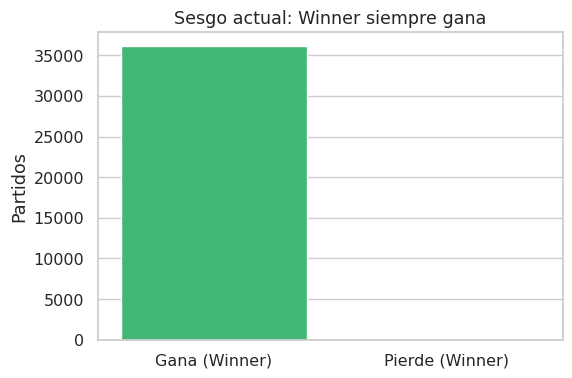

Total partidos: 36076
Problema: Winner gana el 100%


In [49]:
# Actualmente el modelo vería que las columnas "winner_" siempre ganan (100% sesgo)
frecuencia = [len(tennis), 0]
etiquetas = ['Gana (Winner)', 'Pierde (Winner)']

plt.figure(figsize=(6, 4))
sns.barplot(x=etiquetas, y=frecuencia, palette=['#2ecc71', '#e74c3c'])
plt.title('Sesgo actual: Winner siempre gana')
plt.ylabel('Partidos')
plt.show()

print(f"Total partidos: {len(tennis)}")
print("Problema: Winner gana el 100%")

In [50]:
from sklearn.utils import shuffle
import numpy as np

target = 'Winner'

# TRANSFORMACIÓN A FORMATO PLAYER 1 / PLAYER 2

# Detectamos prefijos
cols_w = [c for c in tennis.columns if c.startswith('winner_') or c.startswith('w_')]
cols_l = [c for c in tennis.columns if c.startswith('loser_') or c.startswith('l_')]

# Mapeos de renombrado
# Caso A: winner -> p1, loser -> p2 (target = 1)
map_win_p1 = {c: c.replace('winner_', 'p1_').replace('w_', 'p1_') for c in cols_w}
map_los_p2 = {c: c.replace('loser_', 'p2_').replace('l_', 'p2_') for c in cols_l}
map_case_a = {**map_win_p1, **map_los_p2}

# Caso B: loser -> p1, winner -> p2 (target = 0)
map_los_p1 = {c: c.replace('loser_', 'p1_').replace('l_', 'p1_') for c in cols_l}
map_win_p2 = {c: c.replace('winner_', 'p2_').replace('w_', 'p2_') for c in cols_w}
map_case_b = {**map_los_p1, **map_win_p2}

# Split aleatorio 50/50
np.random.seed(42)
indices = tennis.index.values
idx_a = np.random.choice(indices, size=int(len(indices)/2), replace=False)
idx_b = np.setdiff1d(indices, idx_a)

# Construir los dos datasets
df_a = tennis.loc[idx_a].copy().rename(columns=map_case_a)
df_a[target] = 1

df_b = tennis.loc[idx_b].copy().rename(columns=map_case_b)
df_b[target] = 0

# Concatenar y mezclar
tennis_model = pd.concat([df_a, df_b])
tennis_model = shuffle(tennis_model, random_state=42).reset_index(drop=True)

print(f"Dataset balanceado: {tennis_model[target].value_counts()}")

# CÁLCULO DE DIFERENCIAS
print("Calculando Diferencias (P1 - P2)...")

# Buscamos todas las columnas que existan para P1
p1_cols = [c for c in tennis_model.columns if c.startswith('p1_')]

for p1_col in p1_cols:
    p2_col = p1_col.replace('p1_', 'p2_')
    
    # Si existe la pareja p2_ y es numérica, calculamos la diferencia
    if p2_col in tennis_model.columns:
        if pd.api.types.is_numeric_dtype(tennis_model[p1_col]):
            feat_name = p1_col.replace('p1_', 'diff_')
            tennis_model[feat_name] = tennis_model[p1_col] - tennis_model[p2_col]

print(f"Diferencias calculadas. Total columnas: {tennis_model.shape[1]}")

# LIMPIEZA DE DATA LEAKAGE
print("Eliminando variables con Data Leakage (Stats reales del partido)...")

# Palabras clave que indican data leakage (estadísticas del partido actual)
keywords_prohibidas = [
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced',
    'minutes', 'score', 'games', 'sets', 'minutes', 
    'n_sets', 
    'total_tb', 
    'p1_tb_won', 'p2_tb_won', 
    'diff_tb_won',
    'diff_id'   
]

# Palabras seguras: indican que es un dato histórico calculado previamente
safe_words = ['avg', 'last', 'elo', 'rank', 'h2h', 'days', 'seed', 'hand', 'ht', 'age', 'rec', 'pts', 'rate', 'win_rate']

cols_to_drop = []
for col in tennis_model.columns:
    if col.startswith('p1_') or col.startswith('p2_') or col.startswith('diff_'):
        is_leak = any(bad in col for bad in keywords_prohibidas)
        is_safe = any(safe in col for safe in safe_words)
        
        # Si parece leak Y no tiene "escudo" de seguridad lo eliminamos
        if is_leak and not is_safe:
            cols_to_drop.append(col)

cols_to_drop += ['tourney_id', 'match_num', 'p1_id', 'p2_id', 'p1_name', 'p2_name', 'score', 'round', 'tourney_name', 'month_name', 'p1_ioc', 'p2_ioc']

# Eliminamos duplicados por si acaso
cols_to_drop = list(set(cols_to_drop) & set(tennis_model.columns)) # Solo las que existen

tennis = tennis_model.drop(columns=cols_to_drop)

print(f"Dataset final preparado.")
print(f"Features eliminadas (Leakage/Info): {len(cols_to_drop)}")
print(f"Columnas restantes: {tennis.shape[1]}")
print(tennis.columns.tolist())

Dataset balanceado: Winner
1    18038
0    18038
Name: count, dtype: int64
Calculando Diferencias (P1 - P2)...
Diferencias calculadas. Total columnas: 187
Eliminando variables con Data Leakage (Stats reales del partido)...
Dataset final preparado.
Features eliminadas (Leakage/Info): 55
Columnas restantes: 132
['surface', 'draw_size', 'tourney_level', 'tourney_date', 'p1_seed', 'p1_entry', 'p1_hand', 'p1_ht', 'p1_age', 'p2_seed', 'p2_entry', 'p2_hand', 'p2_ht', 'p2_age', 'best_of', 'minutes', 'p1_rank', 'p1_rank_points', 'p2_rank', 'p2_rank_points', 'year', 'month', 'day', 'tourney_points', 'p1_h2h', 'p2_h2h', 'p1_is_seeded', 'p2_is_seeded', 'p1_is_first_match', 'p2_is_first_match', 'n_sets', 'total_tb', 'p1_1st_won_pct_last_10', 'p1_tb_rate_last_1', 'p1_bp_save_pct_last_5', 'p1_is_rookie', 'p1_df_pct_last_1', 'p1_df_pct_last_10', 'p1_ace_pct_last_1', 'p1_bp_save_pct_lifetime', 'p1_df_pct_last_5', 'p1_tb_rate_last_5', 'p1_tb_won_pct_last_10', 'p1_1st_won_pct_last_1', 'p1_bp_save_pct_las

In [51]:
# Guardar backups de información que necesitamos para IBM
tourney_name_backup = tennis_model['tourney_name'].copy() if 'tourney_name' in tennis_model.columns else None
round_backup = tennis_model['round'].copy() if 'round' in tennis_model.columns else None

# Aseguramos que existan las columnas de fecha (year, month, day)
if 'day' not in tennis.columns and 'tourney_date' in tennis.columns:
    tennis['day'] = pd.to_datetime(tennis['tourney_date']).dt.day
if 'month' not in tennis.columns and 'tourney_date' in tennis.columns:
    tennis['month'] = pd.to_datetime(tennis['tourney_date']).dt.month
if 'year' not in tennis.columns and 'tourney_date' in tennis.columns:
    tennis['year'] = pd.to_datetime(tennis['tourney_date']).dt.year

df_dates_backup = tennis[['year', 'month', 'day']].copy()

# Eliminar columnas redundantes P1/P2 basadas en diff_
diff_cols = [col for col in tennis.columns if col.startswith('diff_')]
base_feature_names = [re.sub(r'^diff_', '', col) for col in diff_cols]

# Construir lista de columnas a eliminar
cols_to_remove = []
for base in base_feature_names:
    p1_target = f"p1_{base}"
    p2_target = f"p2_{base}"
    
    if p1_target in tennis.columns:
        cols_to_remove.append(p1_target)
    if p2_target in tennis.columns:
        cols_to_remove.append(p2_target)

leaks_manuales = ['minutes', 'n_sets', 'total_tb', 'month', 'day']
cols_to_remove += [c for c in leaks_manuales if c in tennis.columns]

tennis = tennis.drop(columns=list(set(cols_to_remove)))

print(f"Feature Selection completada.")
print(f"Eliminadas {len(cols_to_remove)} columnas redundantes P1/P2 y de fuga de información.")
print(f"Columnas restantes: {len(tennis.columns)}")

# Guardar dataset procesado con las fechas, tourney_name y round para IBM (2011-2024)
cols_en_ambos = [c for c in df_dates_backup.columns if c in tennis.columns]
tennis_temp = tennis.drop(columns=cols_en_ambos, errors='ignore')

# Concatenamos las fechas al dataset para IBM
ibm = pd.concat([tennis_temp.reset_index(drop=True), df_dates_backup.reset_index(drop=True)], axis=1)

# Añadir tourney_name y round desde el backup
if tourney_name_backup is not None:
    ibm['tourney_name'] = tourney_name_backup.reset_index(drop=True)

if round_backup is not None:
    ibm['round'] = round_backup.reset_index(drop=True)
    round_order_map = {
        'RR': 1,      # Round Robin
        'BR': 2,      # Bronze Medal Match
        'ER': 3,      # Early Rounds (qualifying)
        'R128': 4,    # Round of 128
        'R64': 5,     # Round of 64
        'R32': 6,     # Round of 32
        'R16': 7,     # Round of 16
        'QF': 8,      # Quarterfinals
        'SF': 9,      # Semifinals
        'F': 10       # Final
    }
    ibm['round_order'] = ibm['round'].map(round_order_map).fillna(0).astype(int)

# Convertir columnas de fecha a int para asegurar compatibilidad con parquet
ibm['year'] = ibm['year'].astype(int)
ibm['month'] = ibm['month'].astype(int)
ibm['day'] = ibm['day'].astype(int)

# Resumen final
print(f"\n Dataset IBM (2011-2024) con fechas, tourney_name y round:")
print(f"   - Filas: {len(ibm)}")
print(f"   - Columnas: {len(ibm.columns)}")
print(f"   - Rango de años: {ibm['year'].min()} - {ibm['year'].max()}")

ibm.to_parquet("data/clean/ibm.parquet", index=False)
tennis.to_parquet("data/clean/atp_matches_train.parquet", index=False)

print("Archivos guardados correctamente.")

Feature Selection completada.
Eliminadas 81 columnas redundantes P1/P2 y de fuga de información.
Columnas restantes: 51

 Dataset IBM (2011-2024) con fechas, tourney_name y round:
   - Filas: 36076
   - Columnas: 56
   - Rango de años: 2011 - 2024
Archivos guardados correctamente.


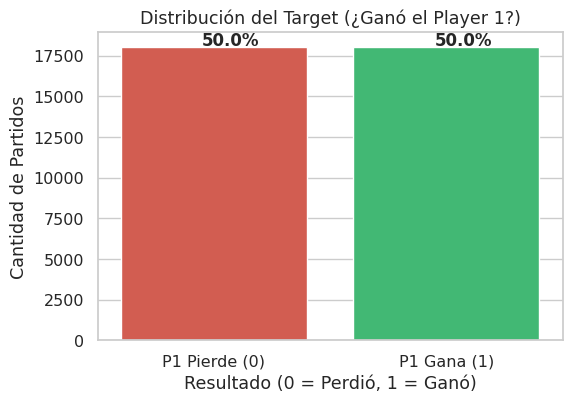

Winner
1    18038
0    18038
Name: count, dtype: int64


In [52]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=target, data=tennis_model, palette=['#e74c3c', '#2ecc71'])

plt.title('Distribución del Target (¿Ganó el Player 1?)')
plt.xlabel('Resultado (0 = Perdió, 1 = Ganó)')
plt.ylabel('Cantidad de Partidos')
plt.xticks([0, 1], ['P1 Pierde (0)', 'P1 Gana (1)'])

total = len(tennis_model)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2 - 0.05
    y = p.get_height() + 100
    ax.annotate(percentage, (x, y), size=12, weight='bold')

plt.show()

print(tennis_model[target].value_counts())

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase C-Separación de los datos

## C.1-División del dataset en train/test 

In [53]:
# División temporal: 2011-2020 train, 2021-2024 test
corte = 2020

tennis_train = tennis[tennis['year'] <= corte].copy()
tennis_test  = tennis[tennis['year'] > corte].copy()

# Eliminamos la columna year ya que no la necesitamos para entrenar
cols_to_drop = ['year']
tennis_train.drop(columns=cols_to_drop, inplace=True)
tennis_test.drop(columns=cols_to_drop, inplace=True)

print(f"Train (2011-2020): {tennis_train.shape[0]} partidos ({(len(tennis_train)/len(tennis))*100:.1f}%)")
print(f"Test  (2021-2024): {tennis_test.shape[0]} partidos ({(len(tennis_test)/len(tennis))*100:.1f}%)")

print(f"\nBalance del Target:")
print(f"Train Target=1: {tennis_train[target].mean():.3f}")
print(f"Test Target=1:  {tennis_test[target].mean():.3f}")


Train (2011-2020): 25155 partidos (69.7%)
Test  (2021-2024): 10921 partidos (30.3%)

Balance del Target:
Train Target=1: 0.498
Test Target=1:  0.504


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase D-Análisis

## D.1-Exploratorio Mínimo

### D.1.1-Introducción al problema

En este dataset, tenemos múltiples variables explicativas que parece razonable pensar que afectan al ganador de un partido de tenis.



In [54]:
tennis_train.shape, tennis_test.shape, tennis.shape

((25155, 50), (10921, 50), (36076, 51))

Tras la división temporal: ~70% train (25k partidos) y ~30% test (11k partidos)

### D.1.2-Formulación del problema

Problema de clasificación binaria: predecir el ganador del partido (0 o 1)



In [55]:
tennis_train['Winner'].value_counts()


Winner
0    12617
1    12538
Name: count, dtype: int64

### D.1.3-Preparación de los datos

Definimos X (features) e y (target):

Como podemos ver en la tabla, en este dataset hay tanto variables numéricas como categóricas.

In [56]:
target = 'Winner'

features = tennis_train.columns.drop(target).tolist()
numerical_features = tennis_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = tennis_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar el target de las numéricas (ya está como 0 o 1)
numerical_features.remove(target)

print("--- Clasificación de Variables ---")
print(f"Target: {target}")
print(f"Numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Categóricas ({len(categorical_features)}): {categorical_features}")
tennis_train['diff_h2h'].head()

--- Clasificación de Variables ---
Target: Winner
Numéricas (42): ['draw_size', 'best_of', 'tourney_points', 'diff_elo_blend', 'diff_days_since', 'diff_injury', 'diff_seed', 'diff_ht', 'diff_age', 'diff_rank', 'diff_rank_points', 'diff_h2h', 'diff_is_seeded', 'diff_is_first_match', 'diff_1st_won_pct_last_10', 'diff_tb_rate_last_1', 'diff_bp_save_pct_last_5', 'diff_is_rookie', 'diff_df_pct_last_1', 'diff_df_pct_last_10', 'diff_ace_pct_last_1', 'diff_bp_save_pct_lifetime', 'diff_df_pct_last_5', 'diff_tb_rate_last_5', 'diff_tb_won_pct_last_10', 'diff_1st_won_pct_last_1', 'diff_bp_save_pct_last_10', 'diff_ace_pct_last_10', 'diff_tb_won_pct_last_5', 'diff_win_rate_last_10', 'diff_1st_won_pct_last_5', 'diff_ace_pct_last_5', 'diff_win_rate_last_5', 'diff_tb_won_pct_last_1', 'diff_1st_won_pct_lifetime', 'diff_win_rate_last_1', 'diff_win_rate_lifetime', 'diff_tb_rate_last_10', 'diff_tb_rate_lifetime', 'diff_bp_save_pct_last_1', 'diff_elo', 'diff_elo_surface']
Categóricas (6): ['surface', 'tourn

0    0
1    0
2    0
3    1
4   -1
Name: diff_h2h, dtype: int64

### D.1.4-Entrando en detalle con la variable objetivo

Hemos visto anteriormente que $Winner$ es una categórica con 3 categorías. Vamos a ver si hay alguna que sobresale de las otras y ver la distribución que sigue.

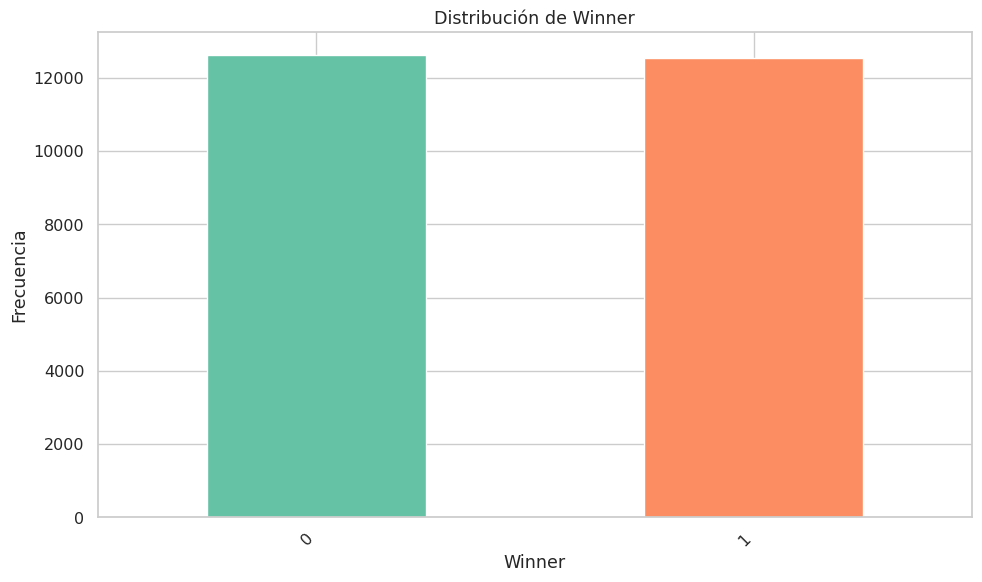

In [57]:
plt.figure(figsize=(10, 6))
counts = tennis_train[target].value_counts()
palette = sns.color_palette("Set2", n_colors=len(counts)) 
ax = counts.plot(kind='bar', color=palette)
ax.set_title('Distribución de Winner')
ax.set_xlabel('Winner')
ax.set_ylabel('Frecuencia')
ax.set_xticklabels(counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

### D.1.5-Variables Explicativas

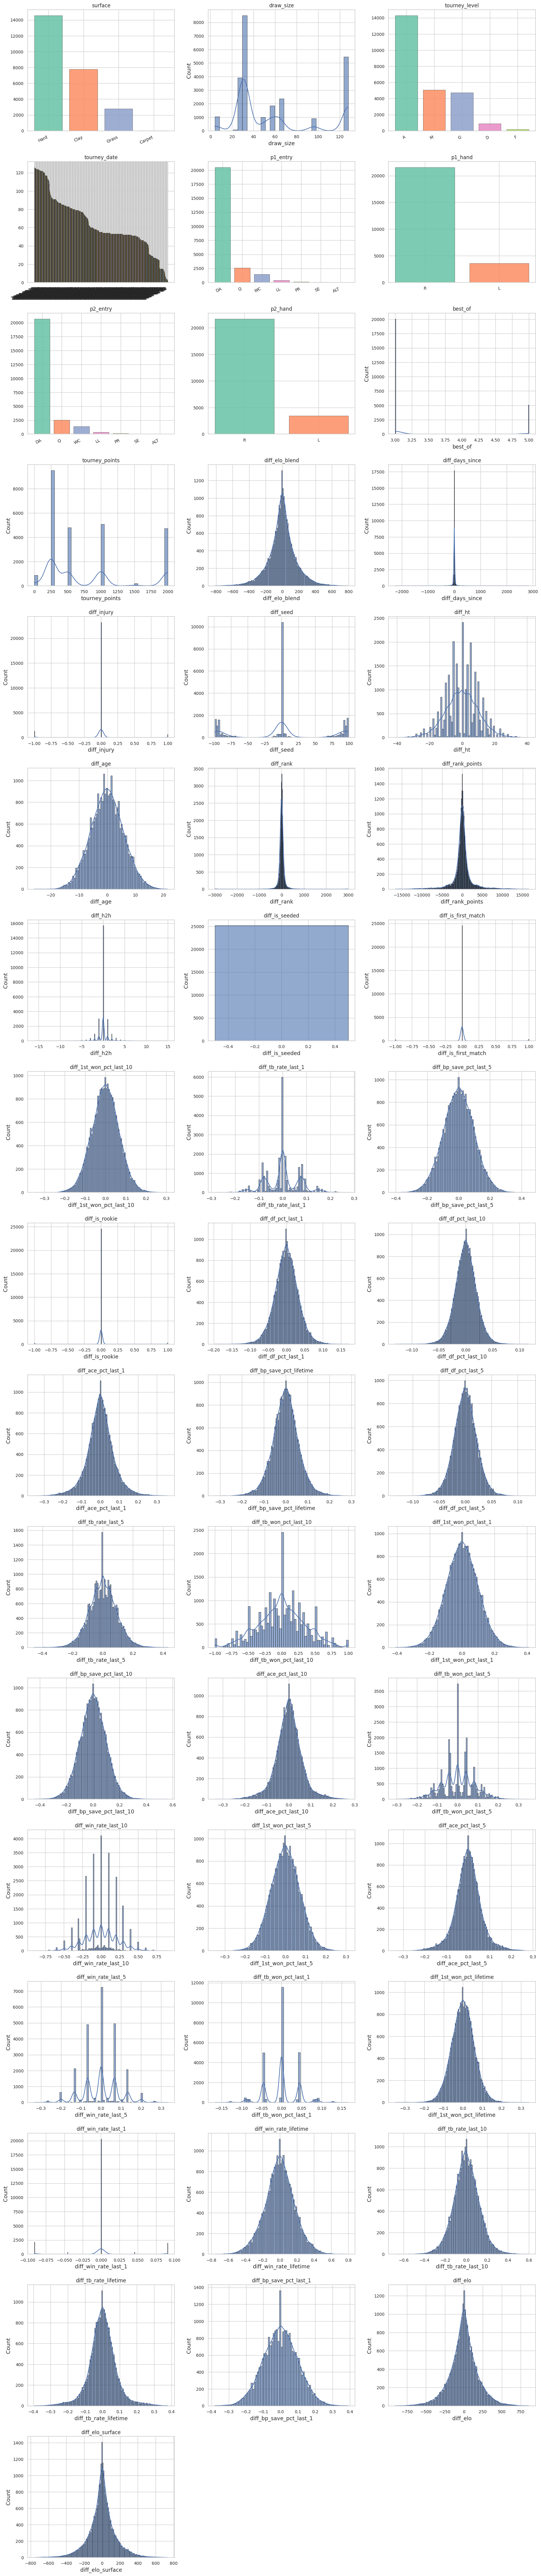

In [58]:
import math
n_rows = math.ceil(len(features) / 3)

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]
    if pd.api.types.is_numeric_dtype(tennis_train[col]):
        # Numéricas
        sns.histplot(
            data=tennis_train,
            x=col,
            kde=True,
            ax=ax,
            stat='count',
            alpha=0.6,
            edgecolor="black",
            linewidth=0.5
        )
    else:
        # Categóricas
        vc = tennis_train[col].value_counts()
        categories = vc.index.astype(str)
        counts = vc.values
        colors = sns.color_palette("Set2", n_colors=len(categories))
        ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black', linewidth=0.4)
        if len(categories) > 3:
            plt.setp(ax.get_xticklabels(), rotation=25, ha='right')

    ax.set_title(col, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### D.1.5.1-Correlación con la variable objetivo $Winner$

En esta sección, analizaremos la relación entre cada variable explicativa y nuestra variable objetivo, $Winner$, para identificar los predictores más influyentes.

### D.1.5.2-Correlaciones por separado

#### Variables Numéricas

Para las variables numéricas miraré la correlacion haciendo un scatter plot para mostrar la relación entre las variables numéricas y la variable objetivo, junto con la H de Kruskal y el p-value.

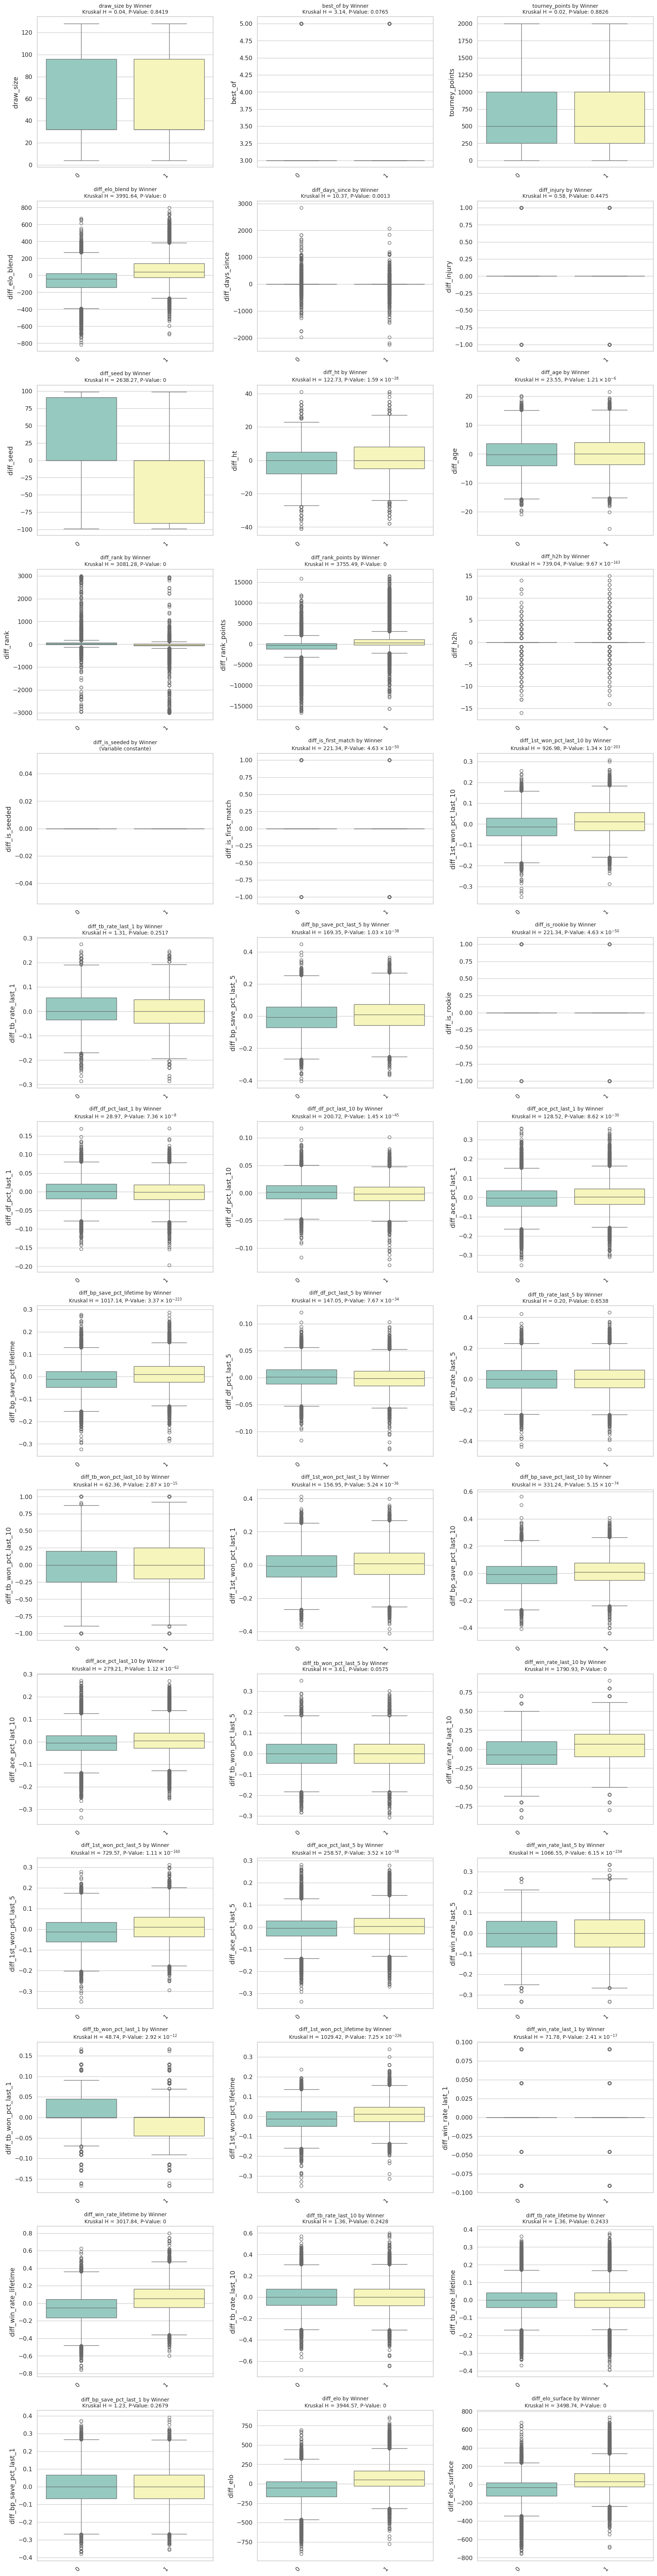

In [59]:
n_rows = math.ceil(len(numerical_features) / 3)
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
order = tennis_train[target].value_counts().index.tolist()
n_cat = len(order)
palette = sns.color_palette("Set3", n_colors=n_cat)

for ax, var in zip(axes.flatten(), numerical_features):
    
    sns.boxplot(x=target, y=var, data=tennis_train, order=order,
                hue=target, dodge=False, palette=palette, ax=ax)

    if ax.get_legend() is not None:
        ax.legend_.remove()

    ax.set_xlabel('')
    ax.set_ylabel(var)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    groups = [g[var].dropna().values for _, g in tennis_train.groupby(target)]
    
    # Verificamos que hay grupos válidos y que hay variabilidad
    if all(len(g) > 0 for g in groups):
        all_values = np.concatenate(groups)
        if len(np.unique(all_values)) > 1:
            try:
                h, p = stats.kruskal(*groups)
                p_str = format_pval(p)
                ax.set_title(f"{var} by {target}\nKruskal H = {h:.2f}, P-Value: {p_str}", fontsize=10)
            except ValueError:
                ax.set_title(f"{var} by {target}\n(No hay variabilidad suficiente)", fontsize=10)
        else:
            ax.set_title(f"{var} by {target}\n(Variable constante)", fontsize=10)
    else:
        ax.set_title(f"{var} by {target}", fontsize=10)

plt.tight_layout()
plt.show()

#### Variables Categóricas

Para las variables categóricas miraré la correlacion haciendo un bar plot para mostrar la relación entre las variables numéricas y la variable objetivo, junto con el p-value.

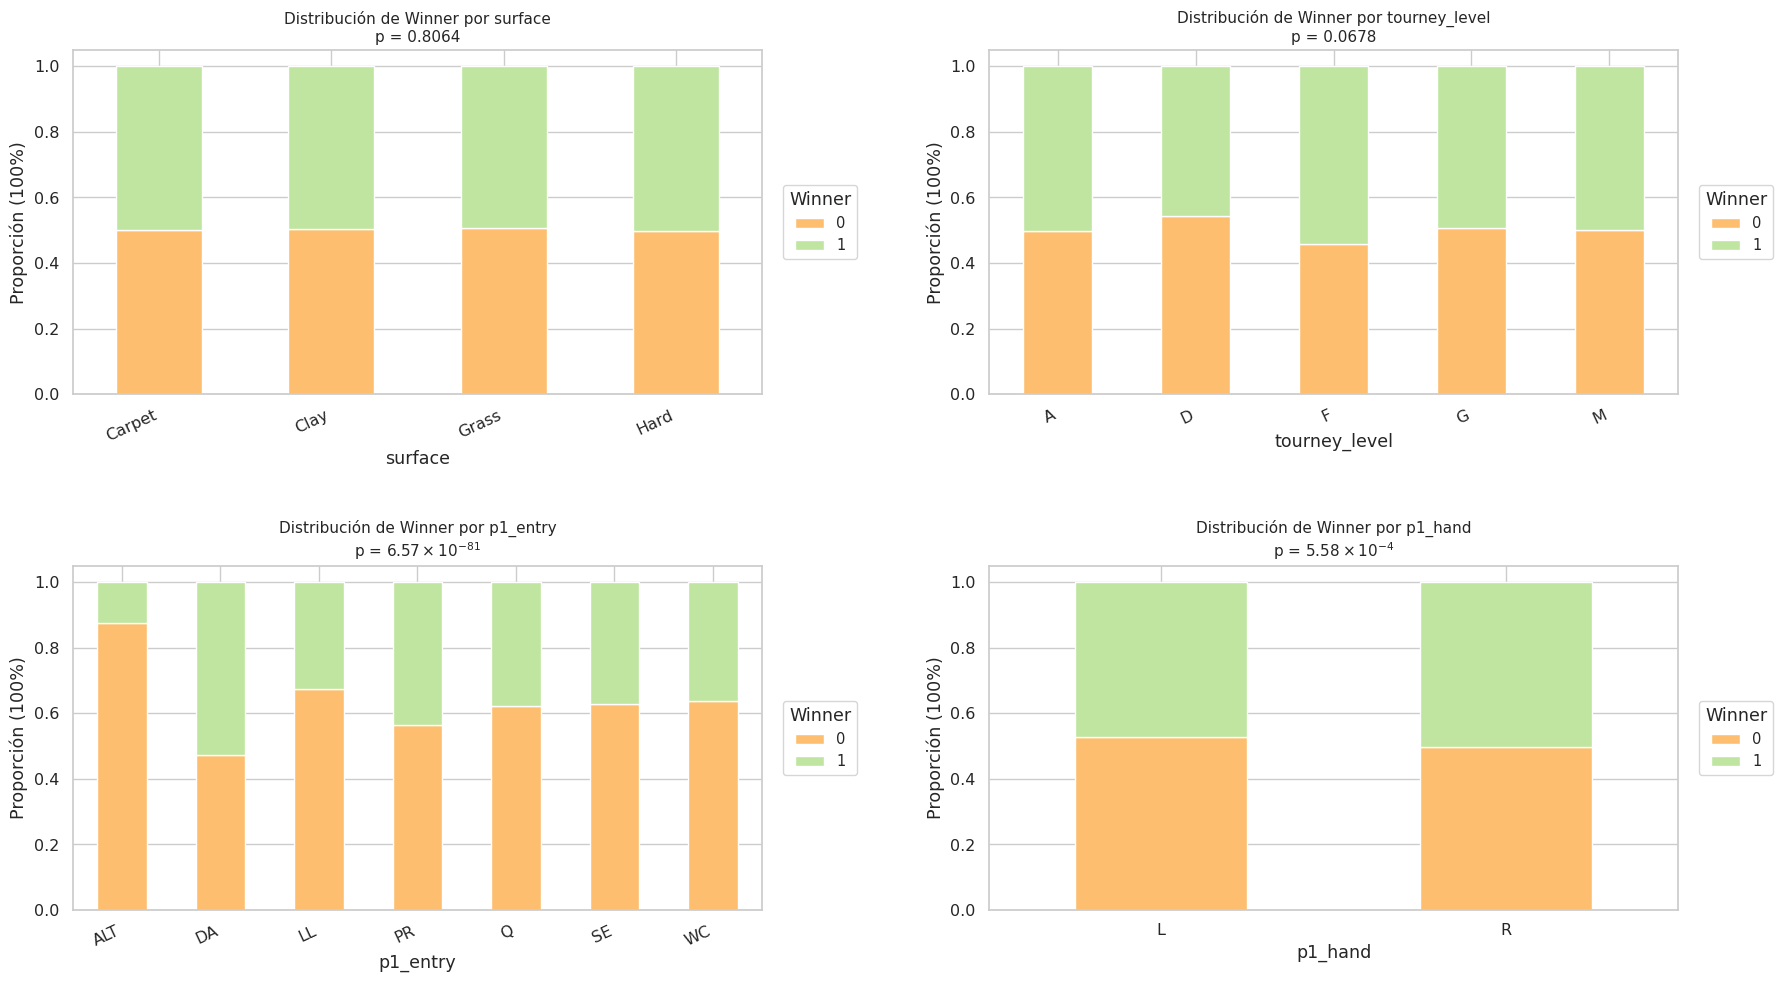

In [60]:
n_rows = math.ceil(len(categorical_features) / 3)
fig, axes = plt.subplots(2,2, figsize=(18, n_rows*5)) 
axes = axes.flatten()
palette = sns.color_palette("Spectral", n_colors=len(tennis_train[target].unique()))

for ax, var in zip(axes, categorical_features):
    ct = pd.crosstab(tennis_train[var], tennis_train[target])
    try:
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        p_str = format_pval(p)
    except Exception:
        p_str = "NA"

    ct_norm = ct.apply(lambda r: r / r.sum(), axis=1)
    colors = palette[:ct_norm.shape[1]]
    ct_norm.plot(kind='bar', stacked=True, ax=ax, color=colors)

    ax.set_title(f"Distribución de {target} por {var}\np = {p_str}", fontsize=11)
    ax.set_xlabel(var)
    ax.set_ylabel("Proporción (100%)")
    if len(ct_norm.index) > 3:
        plt.setp(ax.get_xticklabels(), rotation=25, ha='right')
    else:
        plt.setp(ax.get_xticklabels(), rotation=0)
    ax.legend(title=target, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small')
for ax in axes[len(categorical_features):]:
    ax.axis('off')

plt.tight_layout(w_pad=4.0, h_pad=3.0)
plt.show()

### D.1.6-Matriz de correlaciones


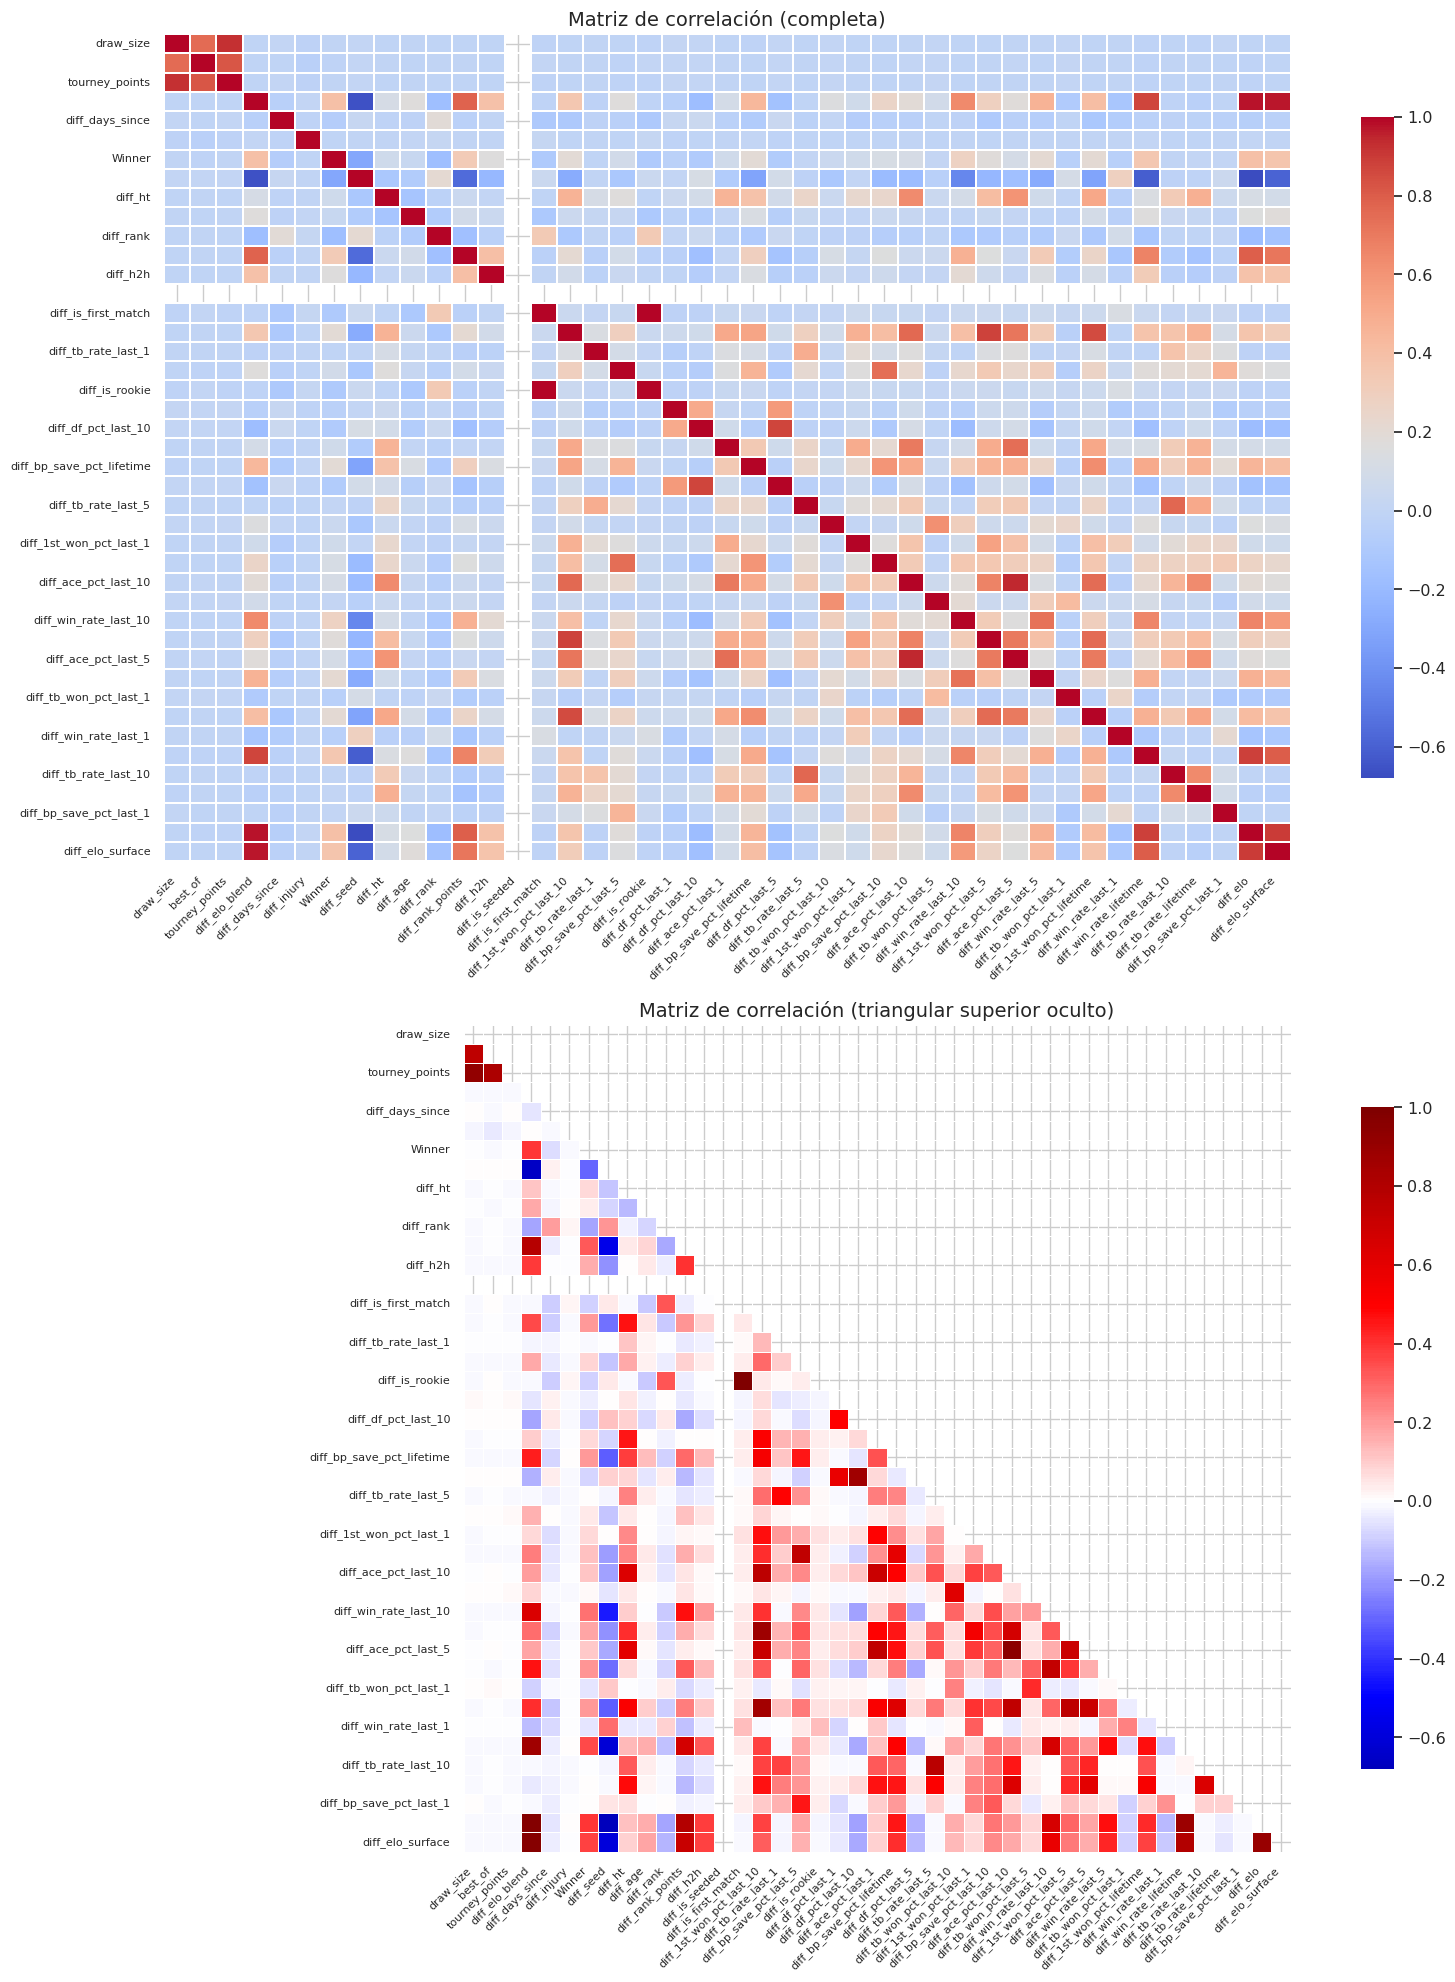

In [61]:
correlation_matrix = tennis_train.corr(numeric_only=True)   
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, axes = plt.subplots(2, 1, figsize=(16, 20))

# Izquierda: SIN anotaciones (son demasiadas variables)
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", ax=axes[0], 
            cbar_kws={"shrink": .8}, linewidths=0.1)
axes[0].set_title("Matriz de correlación (completa)", fontsize=14)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=8)
plt.setp(axes[0].get_yticklabels(), fontsize=8)

# Derecha: CON anotaciones (solo mitad superior)
sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt=".2f", 
            cmap='seismic', center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .8}, ax=axes[1])
axes[1].set_title("Matriz de correlación (triangular superior oculto)", fontsize=14)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=8)
plt.setp(axes[1].get_yticklabels(), fontsize=8)

plt.tight_layout()
plt.show()

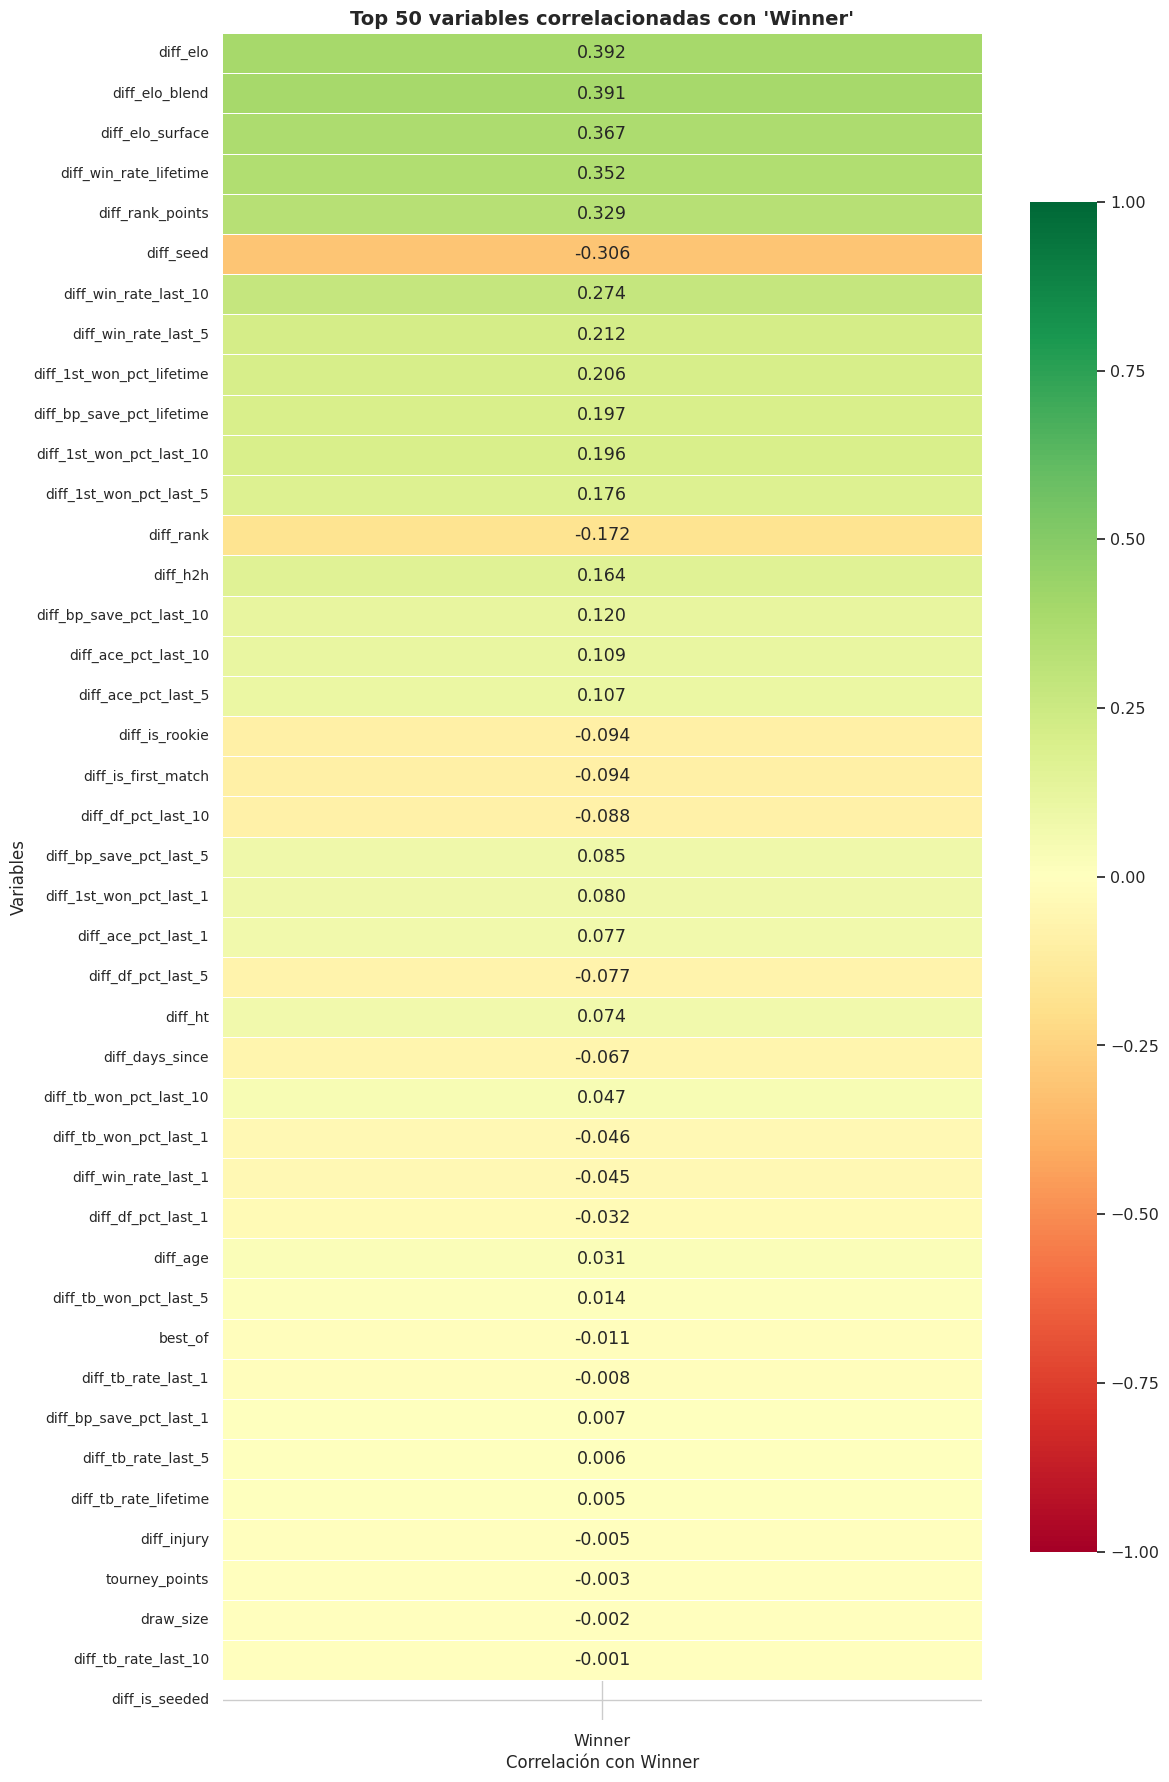


Top 50 correlacionadas con 'Winner':

diff_elo                     0.392221
diff_elo_blend               0.390710
diff_elo_surface             0.367293
diff_win_rate_lifetime       0.352143
diff_rank_points             0.329197
diff_seed                   -0.305505
diff_win_rate_last_10        0.273781
diff_win_rate_last_5         0.212183
diff_1st_won_pct_lifetime    0.205789
diff_bp_save_pct_lifetime    0.197061
diff_1st_won_pct_last_10     0.196044
diff_1st_won_pct_last_5      0.175530
diff_rank                   -0.172188
diff_h2h                     0.163814
diff_bp_save_pct_last_10     0.119921
diff_ace_pct_last_10         0.109379
diff_ace_pct_last_5          0.107256
diff_is_rookie              -0.093804
diff_is_first_match         -0.093804
diff_df_pct_last_10         -0.088315
diff_bp_save_pct_last_5      0.084775
diff_1st_won_pct_last_1      0.080069
diff_ace_pct_last_1          0.077498
diff_df_pct_last_5          -0.076608
diff_ht                      0.074471
diff_days_s

In [62]:
target_corr = correlation_matrix['Winner'].drop('Winner').sort_values(key=abs, ascending=False)

TOP_N = 50
top_features = target_corr.head(TOP_N)

# Crear heatmap horizontal
fig, ax = plt.subplots(figsize=(12, 18))

# Preparar datos para heatmap (1 columna)
top_corr_df = top_features.to_frame()

sns.heatmap(top_corr_df, annot=True, fmt=".3f", cmap='RdYlGn', center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)

ax.set_title(f"Top {TOP_N} variables correlacionadas con 'Winner'", fontsize=14, fontweight='bold')
ax.set_xlabel("Correlación con Winner", fontsize=12)
ax.set_ylabel("Variables", fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTop {TOP_N} correlacionadas con 'Winner':\n")
print(top_features.to_string())

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase Final: Guardar dataset limpio



In [63]:
tennis_train.to_parquet("data/clean/atp_matches_train.parquet", index=False)
tennis_test.to_parquet("data/clean/atp_matches_test.parquet", index=False)

# Guardar dataset IBM
ibm.to_parquet("data/clean/ibm.parquet", index=False)

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Tiempo total de ejecución

In [64]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:00:37.917640
